In [ ]:
!pip install gymnasium[classic_control]
!pip install matplotlib
!pip install torch
!pip install tqdm

In [95]:
from __future__ import annotations

#import essential functions
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import gymnasium as gym

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set all random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)
#for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

import os
os.environ['PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT'] = '2.0'  # set timeout to 2 seconds

# Assignment 3
Student Name: Ji Zhou Wang
Student ID: 260518646

Student Name: Andrew Cook
Student ID: 260781415

Student Name: Philippe Sayegh
Student ID: 260637812

# Useful classes and functions

In [2]:
from sklearn.linear_model import LogisticRegression

#define epsilon-greedy policy
def epsilon_greedy(QF, state, num_actions, epsilon):
    if np.random.uniform() < epsilon:
        # Choose a random action with probability epsilon
        return np.random.choice(num_actions)
    else:
        # Choose the action with highest Q-value for the current state
        #check if QF is a torch neural network, if so retrun the index of the max value given the state
        if isinstance(QF, torch.nn.modules.module.Module):
            return torch.argmax(QF(torch.tensor(state).float().to(device))).item()
        #else if QF is a sklearn logistic regression model, if so retrun the index of the max value given the state
        elif isinstance(QF, LogisticRegression):
            return np.argmax(QF.predict_proba([state]))
        else:
            #else return the index of the max value given the state in QF table
            return np.argmax(QF[state, :])

#define uniform random policy
def uniform_random(num_actions):
    return np.random.choice(num_actions)

#define softmax boltzmann policy
def softmax_boltzmann(Q, state, num_actions, temperature):
    # Calculate the probabilities using the softmax function
    probs = softmax(Q[state, :] / temperature)
    # Choose an action using the calculated probabilities
    return np.random.choice(num_actions, p=probs)

# Define the softmax function prevent overflow
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


In [3]:
#OneHotEncoder for state and action function approximation representation
#Also includes Q-learning algorithm with epsilon greedy policy
class OneHotFA:
    def __init__(self, env, num_bins, actor_weights = None, critic_weights = None):
        self.env = env
        self.num_bins = num_bins
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.bins = self.get_bins()
        self.num_features = self.num_bins ** self.num_states
        self.init_actor_weights = actor_weights
        self.init_critic_weights = critic_weights
        if actor_weights is None: 
            #intialize the starting weights randomly between -0.001 and 0.001 for each feature and action
            self.actor_weights = np.random.uniform(-0.001, 0.001, (self.num_features, self.num_actions))
        else:
            self.actor_weights = actor_weights
        
        if critic_weights is None:
            #initialize critic weights
            self.critic_weights = np.random.uniform(-0.001, 0.001, self.num_features)
        else:
            self.critic_weights = critic_weights

    #print all the parameters of the class
    def print_params(self):
        print("num_bins: " + str(self.num_bins))
        print("num_states: " + str(self.num_states))
        print("num_actions: " + str(self.num_actions))
        print("bins: " + str(self.bins))
        print("num_features: " + str(self.num_features))
        print("weights: " + str(self.actor_weights))
        print("critic_weights: " + str(self.critic_weights))

    #get the bins for each state
    def get_bins(self):
        # compute the bin sizes for position and angle
        # cart_pos_binsize = (self.env.observation_space.high[0] - self.env.observation_space.low[0]) / self.num_bins
        # pole_angle_binsize = (self.env.observation_space.high[2] - self.env.observation_space.low[2]) / self.num_bins

        cart_pos_bin = np.linspace(self.env.observation_space.low[0], self.env.observation_space.high[0], self.num_bins+1)
        pole_angle_bin = np.linspace(self.env.observation_space.low[2], self.env.observation_space.high[2], self.num_bins+1)
        # compute the bins for cart velocity and pole angle velocity
        # calculated from sampling experiment (sd/3)
        cart_vel_bin = [-np.inf, -0.62, -0.46, -0.31, -0.15, 0.0, 0.15, 0.31, 0.46, 0.62, np.inf]
        pole_vel_bin = [-np.inf, -0.99, -0.74, -0.49, -0.24, 0.0, 0.24, 0.49, 0.74, 0.99, np.inf]

        #(sd/2)
        #cart_vel_bin = [-np.inf, -0.93, -0.70, -0.46, -0.23, 0.0, 0.23, 0.46, 0.70, 0.93, np.inf]
        #pole_vel_bin = [-np.inf, -1.49, -1.11, -0.74, -0.37, 0.0, 0.37, 0.74, 1.11, 1.49, np.inf]


        #combine all bins into one array
        bins = np.array([cart_pos_bin, cart_vel_bin, pole_angle_bin, pole_vel_bin])
        # print("bins: " + str(type(bins)) + " " + str(bins.shape))
        # print("bins: " + str(bins))
        return bins
    
    #discretize the input state into a one-hot vector of length num_features for each bin in the bins array corresponding to the state value
    def discretize_state(self, state):
        state_discrete = np.zeros(self.num_features)

        #compute the indices of the bin for each state value
        state_indices = self.get_state_indices(state)
        
        #compute the index of the overall state vector
        state_index = 0
        for i in range(self.num_states):
            state_index += (state_indices[i] - 1) * (self.num_bins ** i)
        
        #assert that the index is within the bounds of the state vector
        assert state_index < self.num_features and state_index >= 0

        #set the index of the overall state vector to 1 for the given state
        state_discrete[state_index] = 1

        return state_discrete, state_index

    #compute the indices of the bin for each state value
    def get_state_indices(self, state):
        state_indices = []
        for i in range(self.num_states):
            state_indices.append(np.digitize(state[i], self.bins[i]))
        return state_indices

    #compute the Q-value for each action with the current actor weights
    def get_Q_actions(self, state_discrete):
        Q_actions = np.dot(state_discrete, self.actor_weights)
        assert Q_actions.shape == (self.num_actions,)
        return Q_actions

    #compute the Q-value for the given state and action with the current actor weights
    def get_Q_action(self, state_discrete, action):
        Q_action = np.dot(state_discrete, self.actor_weights)[action]
        return Q_action
    
    def get_V_critic(self, state_discrete):
        V_critic = np.dot(state_discrete, self.critic_weights)
        return V_critic
    
    #update the weights for the state and action with TD(0)
    def update_weights(self, state_discrete, state_index, action, reward, alpha = 0.01):
        #compute the Q-value for the state and action
        Q = self.get_Q_action(state_discrete, action) #can use state index for more efficient computation
        #compute the TD(0)-error
        td_error = reward - Q
        #update the weights
        self.actor_weights[state_index,action] += alpha * td_error

    #update the weights using SGD with the given batch of experiences
    def update_weights_batch(self, batch, alpha = 0.01):
        #compute the Q-values for the states and actions in the batch
        Q = np.dot(batch[:,0], self.actor_weights)
        #compute the TD(0)-error
        td_error = batch[:,2] - Q
        #update the weights
        self.actor_weights += alpha * np.dot(batch[:,0].T, td_error)

    #Q-learning algorithm with epsilon-greedy policy
    def train_q_learning(self, env, episode_count = 10, alpha=0.5, gamma=0.999, epsilon=0.1, use_decay = False, epsilon_decay=0.999, seed=42):
        # Initialize a table to count the rewards for each episode
        rewards = np.zeros(episode_count)
        # Initialize a table to count the number of steps for each episode
        steps = np.zeros(episode_count)
    
        # Loop over episodes
        for ep_step in range(episode_count):
            # initialize state and action for current episode
            state, info = env.reset(seed=seed) 
            state_discrete, state_index = self.discretize_state(state)
            truncated = False
            terminated = False
            
            # Loop over time steps within the episode
            while not (terminated or truncated):

                # Choose the next action using epsilon-greedy policy
                action = self.epsilon_greedy_FA(epsilon,state_discrete)
                # Take the chosen action and observe the next state and reward
                next_state, reward, terminated, truncated, info = env.step(action)
                # Discretize the next state
                next_state_discrete, next_state_index = self.discretize_state(next_state)

                # Update the Q-value for the current state and action
                if terminated:
                    target = reward
                else:
                    target = reward + gamma * np.max(self.get_Q_actions(next_state_discrete))
                
                # Update the weights for the current state and action
                self.update_weights(state_discrete,state_index, action, target, alpha)

                # Update the state
                state_discrete = next_state_discrete
                state_index = next_state_index
    
                # store the total discounted reward for each episode
                rewards[ep_step] += reward * (gamma ** steps[ep_step])
    
                # store the number of steps for each episode
                steps[ep_step] += 1
    
                env.render()
            
            # Decay the epsilon
            if use_decay:
                epsilon *= epsilon_decay
    
        #return the Q-table and the reward for all episodes
        return self.actor_weights, rewards, steps

    
    # Compute the policy for the given action and state (pi_theta(a,s))
    def get_prob_action(self, action, state_discrete, temperature = 1.0):
        Q_actions = self.get_Q_actions(state_discrete) #logits
        #softmax normalization
        softmax = self.softmax(Q_actions / temperature)
        #return the probability of the given action
        pi = softmax[action]
        return pi
    
    # Choose an action based on the softmax of the Q-values (pi_theta(a,s))
    def get_softmax_action(self, state_discrete, temperature=1.0):
        Q_actions = self.get_Q_actions(state_discrete)
        #softmax normalization
        softmax = self.softmax(Q_actions / temperature)         
        #choose an action based on the softmax
        action = np.random.choice(self.num_actions, p=softmax)
        return action

    # softmax function
    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()


    #reinitialize the weights uniformly
    def reset_weights(self):
        if self.init_actor_weights is not None:
            self.actor_weights = self.init_actor_weights
            #intialize the starting weights randomly between -0.001 and 0.001 for each feature and action
        else:
            self.actor_weights = np.random.uniform(-0.001, 0.001, (self.num_features, self.num_actions))
        
        if self.init_critic_weights is not None:
            self.critic_weights = self.init_critic_weights
        else:
            #initialize critic weights
            self.critic_weights = np.random.uniform(-0.001, 0.001, self.num_features)

    #define epsilon-greedy policy
    def epsilon_greedy_FA(self, epsilon, state_discrete):
        if np.random.uniform() < epsilon:
            # Choose a random action with probability epsilon
            return np.random.choice(self.num_actions)
        else:
            # Choose the action with highest Q-value for the current state
            return np.argmax(self.get_Q_actions(state_discrete))
        

In [4]:
#A2C Advantage Actor-Critic agent network
#code using snippets from https://gymnasium.farama.org/tutorials/gymnasium_basics/vector_envs_tutorial/

class A2C(nn.Module):
    """
    (Synchronous) Advantage Actor-Critic agent class
    Args:
        n_features: The number of features of the input state.
        n_actions: The number of actions the agent can take.
        device: The device to run the computations on (running on a GPU might be quicker for larger Neural Nets,
                for this code CPU is totally fine).
        critic_lr: The learning rate for the critic network (should usually be larger than the actor_lr).
        actor_lr: The learning rate for the actor network.
        critic_weights: The initial weights of the critic network.
        actor_weights: The initial weights of the actor network.
        n_envs: The number of environments that run in parallel (on multiple CPUs) to collect experiences.
    """

    def __init__(
        self,
        n_features: int,
        n_actions: int,
        device: torch.device,
        critic_lr: float,
        actor_lr: float,
        critic_weights: np.ndarray,
        actor_weights: np.ndarray,
        n_envs: int,
    ) -> None:
        """Initializes the actor and critic networks and their respective optimizers."""
        super().__init__()
        self.device = device
        self.n_envs = n_envs

        critic_layers = [nn.Linear(n_features, 1)] # estimate V(s)
        actor_layers = [nn.Linear(n_features, n_actions)] # estimate action logits (will be fed into a softmax later)
        
        # #initialize the weights of the actor and critic networks
        # if critic_weights is not None:
        #     self.critic[0].weight.data = torch.Tensor(critic_weights).to(self.device)
        # else:
        #     #uniformily initialize the weights between -0.001 and 0.001 using nn.init
        #     nn.init.uniform_(self.critic.weight, -0.001, 0.001)
        # if actor_weights is not None:
        #     self.actor[0].weight.data = torch.Tensor(actor_weights).to(self.device)
        # else:
        #     nn.init.uniform_(self.actor.weight, -0.001, 0.001)

        # define actor and critic networks
        self.critic = nn.Sequential(*critic_layers).to(self.device)
        self.actor = nn.Sequential(*actor_layers).to(self.device)

        # define optimizers for actor and critic
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=actor_lr)

    def forward(self, x: np.ndarray) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the networks.

        Args:
            x: A batched vector of states.

        Returns:
            state_values: A tensor with the state values, with shape [n_envs,].
            action_logits_vec: A tensor with the action logits, with shape [n_envs, n_actions].
        """
        x = torch.Tensor(x).to(self.device)
        state_values = self.critic(x)  # shape: [n_envs,]
        action_logits_vec = self.actor(x)  # shape: [n_envs, n_actions]
        return (state_values, action_logits_vec)

    def select_action(
        self, x: np.ndarray
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Returns a tuple of the chosen actions and the log-probs of those actions.

        Args:
            x: A batched vector of states.

        Returns:
            actions: A tensor with the actions, with shape [n_steps_per_update, n_envs].
            action_log_probs: A tensor with the log-probs of the actions, with shape [n_steps_per_update, n_envs].
            state_values: A tensor with the state values, with shape [n_steps_per_update, n_envs].
        """
        state_values, action_logits = self.forward(x)
        action_pd = torch.distributions.Categorical(
            logits=action_logits
        )  # implicitly uses softmax
        actions = action_pd.sample()
        action_log_probs = action_pd.log_prob(actions)
        entropy = action_pd.entropy()
        return (actions, action_log_probs, state_values, entropy)

    def get_losses(
        self,
        rewards: torch.Tensor,
        action_log_probs: torch.Tensor,
        value_preds: torch.Tensor,
        entropy: torch.Tensor,
        masks: torch.Tensor,
        gamma: float,
        lam: float,
        ent_coef: float,
        device: torch.device,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Computes the loss of a minibatch (transitions collected in one sampling phase) for actor and critic
        using Generalized Advantage Estimation (GAE) to compute the advantages (https://arxiv.org/abs/1506.02438).

        Args:
            rewards: A tensor with the rewards for each time step in the episode, with shape [n_steps_per_update, n_envs].
            action_log_probs: A tensor with the log-probs of the actions taken at each time step in the episode, with shape [n_steps_per_update, n_envs].
            value_preds: A tensor with the state value predictions for each time step in the episode, with shape [n_steps_per_update, n_envs].
            masks: A tensor with the masks for each time step in the episode, with shape [n_steps_per_update, n_envs].
            gamma: The discount factor.
            lam: The GAE hyperparameter. (lam=1 corresponds to Monte-Carlo sampling with high variance and no bias,
                                          and lam=0 corresponds to normal TD-Learning that has a low variance but is biased
                                          because the estimates are generated by a Neural Net).
            device: The device to run the computations on (e.g. CPU or GPU).

        Returns:
            critic_loss: The critic loss for the minibatch.
            actor_loss: The actor loss for the minibatch.
        """
        T = len(rewards)
        advantages = torch.zeros(T, self.n_envs, device=device)

        # compute the advantages using GAE
        gae = 0.0
        for t in reversed(range(T - 1)):
            td_error = (
                rewards[t] + gamma * masks[t] * value_preds[t + 1] - value_preds[t]
            )
            gae = td_error + gamma * lam * masks[t] * gae
            advantages[t] = gae

        # calculate the loss of the minibatch for actor and critic
        critic_loss = advantages.pow(2).mean()

        # give a bonus for higher entropy to encourage exploration
        actor_loss = (
            -(advantages.detach() * action_log_probs).mean() - ent_coef * entropy.mean()
        )
        return (critic_loss, actor_loss)

    def update_parameters(
        self, critic_loss: torch.Tensor, actor_loss: torch.Tensor
    ) -> None:
        """
        Updates the parameters of the actor and critic networks.

        Args:
            critic_loss: The critic loss.
            actor_loss: The actor loss.
        """
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()


# Offline RL on CartPole v1 (with linear function approximation or single layer perceptron)

Gathering Expert Data
* Train the expert models before gathering
* Gather 500 behavior episodes in the task using last agent (Actor-Critic)
* Gather 500 episodes using uniformly random policy

Offline Training,
1. Simple imitation learning, use logistic regression to imitate the action observed in each state
2. Fitted Q-learning, using Q-learning targets, only with the batch of data given, K number of iterations on the episodes collected
    1. initialize Q-function randomly between -0.001 and 0.001
    2. Use two different learning rate settings 1/8 and 1/16
3. train with 100, 250, and 500 episodes data (3 data methods x 3 data size = 9 experiments)
    1. Use episodes with expert (Actor-Critic) to train the model
    2. Use episodes with uniform random to train the model
    3. Select at random, half episode from random, half from expert
4. Run greedy policy on the trained model for 100 episodes, and plot the return in a bar chart showing the average and s.d of the return for each of the 9 experiments (6 bars for each data set size) draw two horizontal lines at the average return of the offline RL methods (the same number of episode data). 3 graphs in total.

Write a small report that describes your experiment, including how you decided to stop the training,
the results, and the conclusions you draw from this experimentation. Comment on whether the
algorithms are matching and/or exceeding the performance of the policies used to generate the
data. Comment also on the impact of the data set size and data quality on the results.



In [5]:
# set hyperparameters to gather expert data 
experiment_count = 1
episode_count = 2000 #number of episodes to gather expert data


# set hyperparameters for linear function approximator
bins = 10 #number of bins for discretization as features for linear function approximator
num_states = 4 #number of states
num_features = bins**num_states #number of features for linear function approximator
num_actions = 2 #number of actions


In [6]:
#define initial weights for linear function approximator
critic_weights = np.random.uniform(-0.001, 0.001, num_features)
#actor_weights = np.random.uniform(-0.001, 0.001, (num_features, num_actions)) #different action weights
actor_weights = np.stack((critic_weights, critic_weights), axis=1) #same action weights
actor_weights_ac = np.random.uniform(-0.001, 0.001, (num_actions, num_features))


## A2C data collection
for discrete, could use index to store state space, save memory


In [166]:
# environment hyperparams
n_envs = 1
n_steps_per_update = 500  # number of steps before updating the network, max number of steps
randomize_domain = False

# agent hyperparams
lam = 0.95  # hyperparameter for GAE, TD(lambda) lam = 1 is equivalent to MC, lam = 0 is equivalent to TD(0)
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
alpha = 1/16 #learning rates actor 
beta = 1/4 #learning rates critic (betas are 4x larger than alphas)
gamma = 0.99  # discount factor
device = "cpu"
# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

#initialize arrays to store the average rewards for each episode, each experiment, each alphas for Actor-Critic
critic_losses_ac_nn = np.zeros((experiment_count, episode_count))
actor_losses_ac_nn = np.zeros((experiment_count, episode_count))
entropies_ac_nn = np.zeros((experiment_count, episode_count))
rewards_ac_nn = np.zeros((experiment_count, episode_count))


### Train expert agent

In [ ]:
#training the expert agent
env = gym.make('CartPole-v1', render_mode='rgb_array')
#use encoder to discretize the state space
oh = OneHotFA(env, bins)
env.close()

#define an array to store the state, action, next_state, reward for each episode for each experiment
expert_data_ac_temp = []
#gather data and loop over all experiments for A2C agent
for exp in range(experiment_count):
    print("Experiment: " + str(exp) + " alpha: " + str(alpha) + " beta: " + str(beta))
    
    #initialize the A2C agent
    agent = A2C(num_features, num_actions, device = device, critic_lr=beta, actor_lr=alpha, critic_weights=critic_weights, actor_weights=actor_weights_ac, n_envs=n_envs)
    
    agent.critic[0].weight.data = torch.Tensor(critic_weights).to(device)
    agent.actor[0].weight.data = torch.Tensor(actor_weights_ac).to(device)
    
    #envs = gym.vector.make('CartPole-v1', num_envs=n_envs, render_mode='rgb_array', max_episode_steps=600)
    envs = gym.vector.make('CartPole-v1', num_envs=n_envs)
    # create a wrapper environment to save episode returns and episode lengths
    envs_wrapper = gym.wrappers.RecordEpisodeStatistics(envs, deque_size=n_envs * episode_count)
    

    critic_losses = []
    actor_losses = []
    entropies = []
    episode_data = []
    rewards_each_ep = np.zeros(episode_count)
    
    # use tqdm to get a progress bar for training
    for ep in tqdm(range(episode_count)):
    
        # reset lists that collect experiences of an episode (sample phase)
        ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
        ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
        ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
        masks = torch.zeros(n_steps_per_update, n_envs, device=device)

        #initialize the discrete state space
        state_discrete = np.zeros((n_envs, num_features))
        next_state_discrete = np.zeros((n_envs, num_features))

        # at the start of training reset all envs to get an initial state
        #if ep == 0:
        states, info = envs_wrapper.reset(seed=seed)
        #discretize the state space for each n_envs
        for i in range(n_envs):
            state_discrete[i], _ = oh.discretize_state(states[i])
        truncated = False
        terminated = False
        step = 0
        episode_memory = []
        # play n steps in our parallel environments to collect data
        #for step in range(n_steps_per_update):
        while not (terminated or truncated):
            # select an action A_{t} using S_{t} as input for the agent

            actions, action_log_probs, state_value_preds, entropy = agent.select_action(
                torch.from_numpy(state_discrete).float().unsqueeze(0).to(device=device)
            )
            # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
            states, rewards, terminated, truncated, infos = envs_wrapper.step(
                actions.numpy()[0]
            )
            #store the total discounted rewards for each episode
            rewards_each_ep[ep] += rewards * (gamma ** step)
    
            #discretize the state space for each n_envs
            for i in range(n_envs):
                next_state_discrete[i], _ = oh.discretize_state(states[i])
            

            episode_memory.append((state_discrete.squeeze(), np.array(actions.squeeze().item()), next_state_discrete.squeeze(), rewards.squeeze()))

            state_discrete = next_state_discrete

            ep_value_preds[step] = torch.squeeze(state_value_preds)
            ep_rewards[step] = torch.tensor(rewards, device=device)
            ep_action_log_probs[step] = action_log_probs
    
            # add a mask (for the return calculation later);
            # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
            masks[step] = torch.tensor([not term for term in terminated])
            step += 1


        episode_data.append(np.array(episode_memory))

        
        # calculate the losses for actor and critic
        critic_loss, actor_loss = agent.get_losses(
            ep_rewards,
            ep_action_log_probs,
            ep_value_preds,
            entropy,
            masks,
            gamma,
            lam,
            ent_coef,
            device,
        )
    
        # update the actor and critic networks
        agent.update_parameters(critic_loss, actor_loss)
    
        # log the losses and entropy
        critic_losses.append(critic_loss.detach().cpu().numpy())
        actor_losses.append(actor_loss.detach().cpu().numpy())
        entropies.append(entropy.detach().mean().cpu().numpy())

    #save critic losses for each experiment
    critic_losses_ac_nn[exp, :] = critic_losses
    #save actor losses for each experiment
    actor_losses_ac_nn[exp, :] = actor_losses
    #save entropy for each experiment
    entropies_ac_nn[exp, :] = entropies

    #save the rewards for each episode
    rewards_ac_nn[exp, :] = rewards_each_ep

    #save the episode data
    expert_data_ac_temp.append(np.array(episode_data))

    #close the environment
    envs_wrapper.close()

expert_data_ac_temp = np.array(expert_data_ac_temp).squeeze() #with one experiment use squeeze


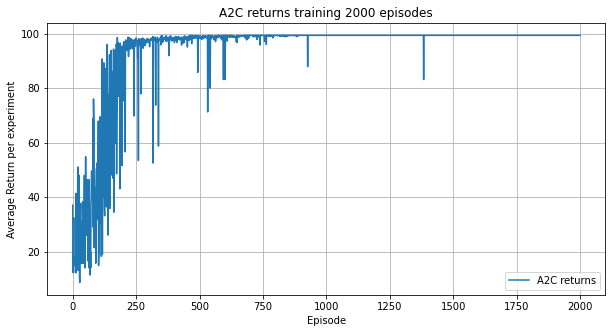

In [60]:
#plot and label the curve with mean over all experiments for each episode for actor and critic nn
#all in one plot
plt.figure(figsize=(10, 5))
plt.plot(np.mean(rewards_ac_nn[:,:], axis=0), label='A2C returns')
plt.xlabel('Episode')
plt.ylabel('Average Return per experiment')
plt.title('A2C returns training 2000 episodes')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#print the shape of the expert data for actor critic
print(expert_data_ac_temp.shape) # number of episodes in first experiment
print(expert_data_ac_temp.squeeze().shape) # number of episodes in first experiment
print(expert_data_ac_temp[0].shape) # number of steps in first episode
print(expert_data_ac_temp[0][0].shape) # shape of first step S_t, A_t, S_t+1, R_t
print(expert_data_ac_temp[0][0]) # first step values S_t, A_t, S_t+1, R_t

### Gathering 500 episodes of expert data A2C

In [167]:
# set hyperparameters to gather expert data 
experiment_count = 1
episode_count = 500 #number of episodes to gather expert data

# set hyperparameters for training
gamma = 0.99 #discount factor


# set hyperparameters for linear function approximator
bins = 10 #number of bins for discretization as features for linear function approximator
num_features = bins**num_states #number of features for linear function approximator
num_actions = 2 #number of actions

#initialize arrays to store the average rewards for each episode, each experiment, each alphas for Actor-Critic
critic_losses_ac_nn = np.zeros((experiment_count, episode_count))
actor_losses_ac_nn = np.zeros((experiment_count, episode_count))
entropies_ac_nn = np.zeros((experiment_count, episode_count))
rewards_ac_nn = np.zeros((experiment_count, episode_count))

In [168]:
#save A2C agent model weights using torch save
# torch.save(agent.critic[0].weight.data, 'critic_weights_ac_nn.pt')
# torch.save(agent.actor[0].weight.data, 'actor_weights_ac_nn.pt')


#load agent model using torch load
agent = A2C(num_features, num_actions, device = device, critic_lr=beta, actor_lr=alpha, critic_weights=critic_weights, actor_weights=actor_weights_ac, n_envs=n_envs)

#print
print(agent)
#print agent weights
print(agent.critic[0].weight.data)
print(agent.actor[0].weight.data)

#load agent model weights using torch load
agent.critic[0].weight.data = torch.load('critic_weights_ac_nn.pt')
agent.actor[0].weight.data = torch.load('actor_weights_ac_nn.pt')

#print agent weights
print(agent.critic[0].weight.data)
print(agent.actor[0].weight.data)

A2C(
  (critic): Sequential(
    (0): Linear(in_features=10000, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=10000, out_features=2, bias=True)
  )
)
tensor([[-0.0039,  0.0041, -0.0052,  ...,  0.0086,  0.0091,  0.0014]])
tensor([[-7.7727e-03,  9.1565e-03, -4.7698e-03,  ...,  4.6744e-05,
          5.9592e-03, -1.1696e-03],
        [ 9.1872e-03,  5.5586e-03, -2.1535e-03,  ...,  6.6312e-03,
          6.1404e-03, -2.6132e-03]])
tensor([-0.0003,  0.0009,  0.0005,  ...,  0.0009, -0.0002, -0.0006])
tensor([[-0.0003, -0.0003, -0.0006,  ..., -0.0004, -0.0001, -0.0007],
        [ 0.0005, -0.0006, -0.0003,  ..., -0.0010, -0.0002, -0.0005]])


In [169]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
#use encoder to discretize the state space
oh = OneHotFA(env, bins)
env.close()

#define an array to store the state, action, next_state, reward for each episode for each experiment
expert_data_ac = []
expert_data_ac_discrete = []

#gather data and loop over all experiments for A2C agent
for exp in range(experiment_count):
    print("Experiment: " + str(exp) + " alpha: " + str(alpha) + " beta: " + str(beta))
    
    #using the previous trained A2C agent
    
    #envs = gym.vector.make('CartPole-v1', num_envs=n_envs, render_mode='rgb_array', max_episode_steps=600)
    envs = gym.vector.make('CartPole-v1', num_envs=n_envs)
    #create a wrapper environment to save episode returns and episode lengths
    envs_wrapper = gym.wrappers.RecordEpisodeStatistics(envs, deque_size=n_envs * episode_count)
    
    critic_losses = []
    actor_losses = []
    entropies = []
    episode_data = []
    episode_data_discrete = []

    rewards_each_ep = np.zeros(episode_count)
    
    # use tqdm to get a progress bar for training
    for ep in tqdm(range(episode_count)):
    
        # reset lists that collect experiences of an episode (sample phase)
        ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
        ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
        ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
        masks = torch.zeros(n_steps_per_update, n_envs, device=device)

        #initialize the discrete state space
        state_discrete = np.zeros((n_envs, num_features))
        next_state_discrete = np.zeros((n_envs, num_features))

        # at the start of training reset all envs to get an initial state
        #if ep == 0:
        states, info = envs_wrapper.reset(seed=seed)
        #discretize the state space for each n_envs
        for i in range(n_envs):
            state_discrete[i], _ = oh.discretize_state(states[i])
        truncated = False
        terminated = False
        step = 0
        episode_memory = []
        episode_memory_discrete = []
        # play n steps in our parallel environments to collect data
        #for step in range(n_steps_per_update):
        while not (terminated or truncated):
            actions, action_log_probs, state_value_preds, entropy = agent.select_action(
                torch.from_numpy(state_discrete).float().unsqueeze(0).to(device=device)
            )
            # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
            next_states, rewards, terminated, truncated, infos = envs_wrapper.step(
                actions.numpy()[0]
            )
            #store the total discounted rewards for each episode
            rewards_each_ep[ep] += rewards * (gamma ** step)
    
            #discretize the state space for each n_envs
            for i in range(n_envs):
                next_state_discrete[i], _ = oh.discretize_state(next_states[i])
            

            episode_memory.append((states[0].squeeze(), np.array(actions.squeeze().item()), next_states[0].squeeze(), rewards.squeeze()))
            episode_memory_discrete.append((state_discrete[0].squeeze(), np.array(actions.squeeze().item()), next_state_discrete[0].squeeze(), rewards.squeeze()))

            state_discrete = next_state_discrete

            ep_value_preds[step] = torch.squeeze(state_value_preds)
            ep_rewards[step] = torch.tensor(rewards, device=device)
            ep_action_log_probs[step] = action_log_probs
    
            # add a mask (for the return calculation later);
            # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
            masks[step] = torch.tensor([not term for term in terminated])
            step += 1

        episode_data.append(np.array(episode_memory))
        episode_data_discrete.append(np.array(episode_memory_discrete))
        
        # calculate the losses for actor and critic
        critic_loss, actor_loss = agent.get_losses(
            ep_rewards,
            ep_action_log_probs,
            ep_value_preds,
            entropy,
            masks,
            gamma,
            lam,
            ent_coef,
            device,
        )
    
        # update the actor and critic networks
        agent.update_parameters(critic_loss, actor_loss)
    
        # log the losses and entropy
        critic_losses.append(critic_loss.detach().cpu().numpy())
        actor_losses.append(actor_loss.detach().cpu().numpy())
        entropies.append(entropy.detach().mean().cpu().numpy())

    #save critic losses for each experiment
    critic_losses_ac_nn[exp, :] = critic_losses
    #save actor losses for each experiment
    actor_losses_ac_nn[exp, :] = actor_losses
    #save entropy for each experiment
    entropies_ac_nn[exp, :] = entropies

    #save the rewards for each episode
    rewards_ac_nn[exp, :] = rewards_each_ep

    #save the episode data
    expert_data_ac.append(np.array(episode_data))
    expert_data_ac_discrete.append(np.array(episode_data_discrete))

    #close the environment
    envs_wrapper.close()

expert_data_ac = np.array(expert_data_ac).squeeze() #with one experiment use squeeze
expert_data_ac_discrete = np.array(expert_data_ac_discrete).squeeze() #with one experiment use squeeze



Experiment: 0 alpha: 0.0625 beta: 0.25
















c:\Users\ccarc\Anaconda3\envs\torch_gpu_wv\lib\site-packages\ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
c:\Users\ccarc\Anaconda3\envs\torch_gpu_wv\lib\site-packages\ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


























































































































































































































































































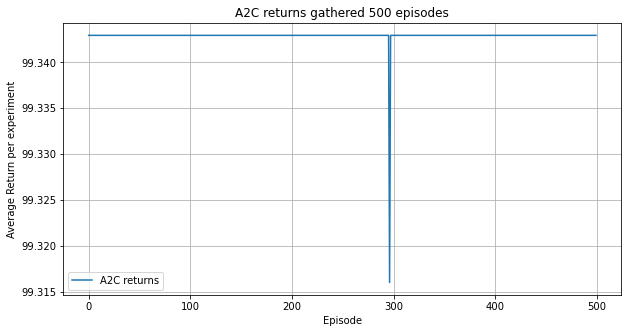

In [170]:
#plot and label the curve with mean over all experiments for each episode for actor and critic nn
#all in one plot
plt.figure(figsize=(10, 5))
plt.plot(np.mean(rewards_ac_nn[:,:], axis=0), label='A2C returns')
plt.xlabel('Episode')
plt.ylabel('Average Return per experiment')
plt.title('A2C returns gathered 500 episodes')
plt.legend()
plt.grid()
plt.show()

In [171]:
def flatten_array(arr):
    """
    Flattens a numpy array of shape (500, 500, 4) to an array of shape (500,)
    where each element is a variable-length array of shape (500, 4).
    """
    flattened = np.empty(shape=(arr.shape[0],), dtype=object)
    for i in range(arr.shape[0]):
        flattened[i] = arr[i, :, :]
    return flattened
#create variable size array to combine data later
if len(expert_data_ac.shape) == 3:
    expert_data_ac = flatten_array(expert_data_ac)

#same for discrete data
if len(expert_data_ac_discrete.shape) == 3:
    expert_data_ac_discrete = flatten_array(expert_data_ac_discrete)

In [172]:
#print the shape of the expert data for actor critic
#shape shows every episode ended up with optimal reward eg. 500 steps
print(expert_data_ac.shape) # number of episodes in first experiment
print(expert_data_ac.squeeze().shape) # number of episodes in first experiment
print(expert_data_ac[0].shape) # number of steps in first episode
print(expert_data_ac[0][0].shape) # shape of first step S_t, A_t, S_t+1, R_t
print(expert_data_ac[0][0]) # first step values S_t, A_t, S_t+1, R_t

(500,)
(500,)
(500, 4)
(4,)
[array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)
 array(1)
 array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)
 array(1.)]


In [37]:
#print the shape of the expert data discrete for actor critic
#shape shows every episode ended up with optimal reward eg. 500 steps
print(expert_data_ac_discrete.shape) # number of episodes in first experiment
print(expert_data_ac_discrete.squeeze().shape) # number of episodes in first experiment
print(expert_data_ac_discrete[0].shape) # number of steps in first episode
print(expert_data_ac_discrete[0][0].shape) # shape of first step S_t, A_t, S_t+1, R_t
print(expert_data_ac_discrete[0][0]) # first step values S_t, A_t, S_t+1, R_t


(500,)
(500,)
(500, 4)
(4,)
[array([0., 0., 0., ..., 0., 0., 0.]) array(1)
 array([0., 0., 0., ..., 0., 0., 0.]) array(1.)]


### Gather 500 episodes using Uniform random policy

In [152]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
#use encoder to discretize the state space
oh = OneHotFA(env, bins)
env.close()

expert_data_uf = []
expert_data_uf_discrete = []

#gather data and loop over all experiments for uniformly random policy
rewards_uf = np.zeros((experiment_count, episode_count))

for exp in range(experiment_count):
    print("Uniform random policy Experiment: " + str(exp))
    #initialize the environment
    env = gym.make('CartPole-v1', render_mode='rgb_array')

    # Initialize a table to count the rewards for each episode
    rewards_each_ep = np.zeros(episode_count)
    episode_data = []
    episode_data_discrete = []

    # Initialize a table to count the number of steps for each episode
    steps = np.zeros(episode_count)

    # Loop over episodes
    for ep in tqdm(range(episode_count)):
        # initialize state and action for current episode
        state, info = env.reset(seed=seed) 
        state_discrete, _ = oh.discretize_state(state)

        truncated = False
        terminated = False
        
        episode_memory = []
        episode_memory_discrete = []
        
        # Loop over time steps within the episode
        while not (terminated or truncated):
            # Choose the next action using uniform random policy
            action = uniform_random(num_actions)
            # Take the chosen action and observe the next state and reward
            next_state, reward, terminated, truncated, info = env.step(action)
            next_state_discrete, _ = oh.discretize_state(next_state)

            # store the total reward for each episode
            rewards_each_ep[ep] += reward * (gamma ** steps[ep])

            episode_memory.append((state, np.asarray(action), next_state, np.asarray(reward)))
            episode_memory_discrete.append((state_discrete, np.asarray(action), next_state_discrete, np.asarray(reward)))          

            # store the number of steps for each episode
            steps[ep] += 1
            env.render()

        episode_data.append(np.array(episode_memory))
        episode_data_discrete.append(np.array(episode_memory_discrete))

    #save the rewards for each episode
    rewards_uf[exp, :] = rewards_each_ep

    #save the episode data
    expert_data_uf.append(np.array(episode_data))
    expert_data_uf_discrete.append(np.array(episode_data_discrete))

    #close the environment
    env.close()

expert_data_uf = np.array(expert_data_uf).squeeze() #with one experiment use squeeze
expert_data_uf_discrete = np.array(expert_data_uf_discrete).squeeze() #with one experiment use squeeze

Uniform random policy Experiment: 0


c:\Users\ccarc\Anaconda3\envs\torch_gpu_wv\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
c:\Users\ccarc\Anaconda3\envs\torch_gpu_wv\lib\site-packages\ipykernel_launcher.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.








































































































































































































































































































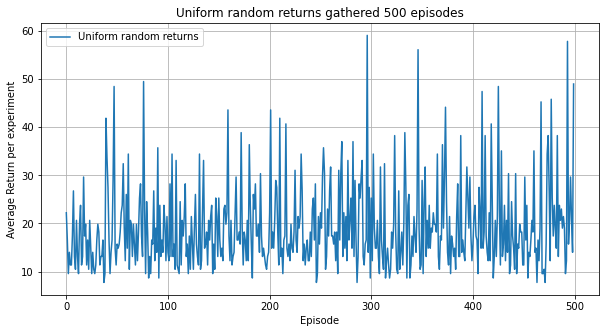

In [153]:
#plot and label the curve with mean over all experiments for each episode for uniformly random policy
#all in one plot
plt.figure(figsize=(10, 5))
plt.plot(np.mean(rewards_uf[:,:], axis=0), label='Uniform random returns')
plt.xlabel('Episode')
plt.ylabel('Average Return per experiment')
plt.title('Uniform random returns gathered 500 episodes')
plt.legend()
plt.grid()
plt.show()

In [154]:
#print the shape of the expert data for uniformly random policy
print(expert_data_uf.shape) # number of episodes
print(expert_data_uf[0].shape) # number of steps in first episode
print(expert_data_uf[0].shape[0]) # number of steps in first episode
print(expert_data_uf[0][0].shape) # shape of first step S_t, A_t, S_t+1, R_t
print(expert_data_uf[0][0]) # first step values S_t, A_t, S_t+1, R_t
print(expert_data_uf[0][0][0]) # first step values S_t
print(expert_data_uf[0][0][1]) # first step values A_t


(500,)
(25, 4)
25
(4,)
[array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)
 array(0)
 array([ 0.02727336, -0.20172954,  0.03625453,  0.32351476], dtype=float32)
 array(1.)]
[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
0


In [155]:
#print the shape of the expert data discrete for uniformly random policy
print(expert_data_uf_discrete.shape) # number of episodes
print(expert_data_uf_discrete[0].shape) # number of steps in first episode
print(expert_data_uf_discrete[0].shape[0]) # number of steps in first episode
print(expert_data_uf_discrete[0][0].shape) # shape of first step S_t, A_t, S_t+1, R_t
print(expert_data_uf_discrete[0][0]) # first step values S_t, A_t, S_t+1, R_t
print(expert_data_uf_discrete[0][0][0]) # first step values S_t
print(expert_data_uf_discrete[0][0][1]) # first step values A_t


(500,)
(25, 4)
25
(4,)
[array([0., 0., 0., ..., 0., 0., 0.]) array(0)
 array([0., 0., 0., ..., 0., 0., 0.]) array(1.)]
[0. 0. 0. ... 0. 0. 0.]
0


In [156]:
#randomly select half of the indices from expert_data_ac and half of the indices from expert_data_uf episodes
#from a list of indices length of episodes
indices = list(range(episode_count))
random.shuffle(indices)
print(indices)

#select half of the indices from expert_data_ac and half of the indices from expert_data_uf episodes
#combine them in a new array called expert_data_ac_uf
expert_data_ac_uf = np.empty((episode_count), dtype=object)
for i in range(episode_count):
    if i < episode_count/2:
        expert_data_ac_uf[indices[i]] = expert_data_ac[indices[i]]
    else:
        expert_data_ac_uf[indices[i]] = expert_data_uf[indices[i]]

#same for discrete
expert_data_ac_uf_discrete = np.empty((episode_count), dtype=object)
for i in range(episode_count):
    if i < episode_count/2:
        expert_data_ac_uf_discrete[indices[i]] = expert_data_ac_discrete[indices[i]]
    else:
        expert_data_ac_uf_discrete[indices[i]] = expert_data_uf_discrete[indices[i]]

expert_data_ac_uf = np.array(expert_data_ac_uf).squeeze() #with one experiment use squeeze
expert_data_ac_uf_discrete = np.array(expert_data_ac_uf_discrete).squeeze() #with one experiment use squeeze

[164, 383, 45, 156, 53, 72, 315, 209, 74, 333, 403, 415, 92, 215, 479, 59, 368, 163, 210, 251, 443, 320, 289, 389, 7, 462, 249, 228, 245, 211, 129, 162, 223, 41, 278, 21, 434, 68, 227, 151, 369, 217, 154, 177, 397, 139, 141, 326, 175, 170, 88, 96, 439, 303, 50, 199, 297, 131, 120, 358, 180, 370, 37, 160, 4, 93, 304, 188, 374, 453, 94, 468, 292, 340, 407, 408, 187, 334, 213, 127, 11, 6, 442, 246, 396, 425, 345, 89, 426, 26, 77, 184, 262, 207, 182, 95, 100, 419, 394, 155, 230, 362, 237, 353, 85, 323, 171, 393, 153, 313, 38, 392, 69, 106, 348, 489, 428, 158, 31, 244, 8, 267, 485, 233, 261, 401, 291, 198, 132, 324, 322, 2, 18, 488, 263, 76, 253, 314, 351, 471, 143, 449, 66, 179, 133, 144, 406, 280, 269, 466, 208, 145, 432, 277, 341, 465, 317, 17, 448, 20, 130, 238, 296, 286, 336, 300, 149, 203, 387, 398, 190, 201, 418, 14, 55, 75, 284, 39, 391, 460, 257, 178, 212, 472, 420, 67, 99, 476, 97, 196, 339, 288, 318, 457, 124, 242, 42, 60, 192, 422, 266, 254, 384, 497, 226, 495, 113, 19, 218, 118

In [157]:
#print the shape of the expert data for actor critic and uniformly random policy
print(expert_data_ac_uf.shape) # number of episodes
print(expert_data_ac_uf[164].shape) # (number of steps in first episode, num_states)
print(expert_data_ac_uf[0].shape[0]) # number of steps in first episode
print(expert_data_ac_uf[0][0].shape) # shape of first step S_t, A_t, S_t+1, R_t
print(expert_data_ac_uf[0][0]) # first step values S_t, A_t, S_t+1, R_t
print(expert_data_ac_uf[0][0][0].shape) # first step values S_t
print(expert_data_ac_uf[0][0][1]) # first step values A_t



(500,)
(500, 4)
25
(4,)
[array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)
 array(0)
 array([ 0.02727336, -0.20172954,  0.03625453,  0.32351476], dtype=float32)
 array(1.)]
(4,)
0


In [158]:
#stack all data into one array
expert_data_all = np.stack((expert_data_ac, expert_data_uf,expert_data_ac_uf), axis=0)
expert_data_all_discrete = np.stack((expert_data_ac_discrete, expert_data_uf_discrete,expert_data_ac_uf_discrete), axis=0)

#save the expert data #very large!!!
# np.save('expert_data_all.npy', expert_data_all)
# np.save('expert_data_all_discrete.npy', expert_data_all_discrete)


## Offline RL
Using expert data
A2C: expert_data_ac
Uniform random: expert_data_uf

In [159]:
# set hyperparameters for training
episode_cs = [100, 250, 500] # number of episode sizes to select from in each experiment
gamma = 0.99 # discount factor

learning_rate = 0.001 #test different learning rates for different optimizers (Adam, SGD)
tolerance = 1e-6 #tolerance for convergence
s = 1 #batch split factor
k = 3 #number of iterations for each full batch episodes

#define a dictionary to map the method names to the corresponding data
method_dict = {0 : 'AC', 1 : 'UF', 2 : 'AC_UF'}

# Define the Function Approximator for fitted Q
class SD_Net(nn.Module):
    def __init__(self, state_size, action_size):
        super(SD_Net, self).__init__()
        self.linear = nn.Linear(state_size, action_size)
        nn.init.uniform_(self.linear.weight, a=-0.001, b=0.001)

    def forward(self, x):
        out = self.linear(x)
        return torch.sigmoid(out) #use sigmoid activation function
        #return out #use linear activation function

### Simple imitation learning

In [ ]:
#batch training for all agent in imitation learning
learning_rate_C = 0.1 #learning rate for logistic regression
#initialize an array to store all 9 experiment agents
iml_sdnets = np.zeros(9, dtype=object)
agent_index = 0

#loop through the selected data lengths
for selected_data in range(len(episode_cs)):
    #loop through the selected methods
    for selected_method in tqdm(range(len(expert_data_all_discrete))):
        iml_sdnet = LogisticRegression(C=learning_rate_C)
        batch_size = episode_cs[selected_data]

        # Fit over episodes in selected batch indices
        batch_indices = np.arange(0, batch_size)
        #print(batch_indices)

        expert_batch = expert_data_all_discrete[selected_method][batch_indices]
        
        #initialize the X and y arrays of size 
        X = np.empty((0, 10000))
        y = np.array([])
        # Loop over time steps within the episode (load the batches of data)
        for i, expert_data in enumerate(expert_batch):            
            states = np.stack([np.array(a) for a in expert_data[:, 0]]).astype(np.float32)
            actions = np.stack([np.array(a) for a in expert_data[:, 1]]).astype(np.int64)
            next_inputs = np.stack([np.array(a) for a in expert_data[:, 2]]).astype(np.float32)
            rewards = np.stack([np.array(a) for a in expert_data[:, 3]]).astype(np.float32)
            step_size = expert_data.shape[0]

            #append the states to X
            #append the actions to y
            X = np.concatenate((X, states), axis=0)
            y = np.append(y, actions)

        assert len(X) == len(y)

        iml_sdnet.fit(X, y)

        #save the trained agent
        iml_sdnets[agent_index] = iml_sdnet
        agent_index += 1

In [191]:
#save the trained agents
#np.save('iml_sdnets_clr_1', iml_sdnets)
#np.save('iml_sdnets_clr_01', iml_sdnets)
#np.save('iml_sdnets_clr_001', iml_sdnets)

#load the trained agents
iml_sdnets = np.load('iml_sdnets_clr_1.npy', allow_pickle=True)
#iml_sdnets = np.load('iml_sdnets_clr_01.npy', allow_pickle=True)
#iml_sdnets = np.load('iml_sdnets_clr_001.npy', allow_pickle=True)

#### Greedy test run

In [192]:
#online greedy testing parameters
episode_count = 100

#initialize an array to store the rewards for each episode for each agent
rewards_iml = np.zeros((9, episode_count))

#loop through each agent
for i, q_agent in enumerate(iml_sdnets):

    #Offline training using expert data on a policy network model (supervised)
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    #use encoder to for Fitted Q-learning and discretize the state space
    oh = OneHotFA(env, bins)

    # Initialize a table to count the rewards for each episode
    rewards = np.zeros(episode_count)
    # Initialize a table to count the number of steps for each episode
    steps = np.zeros(episode_count)

    # Loop over episodes
    for ep in range(episode_count):
        # initialize state and action for current episode
        state, info = env.reset(seed=seed) 
        state_discrete, state_index = oh.discretize_state(state)
        truncated = False
        terminated = False

        # Loop over time steps within the episode
        while not (terminated or truncated):

            # Choose the next action using greedy policy
            action = np.argmax(q_agent.predict_proba([state_discrete]))

            # Take the chosen action and observe the next state and reward
            next_state, reward, terminated, truncated, info = env.step(action)
            # Discretize the next state
            next_state_discrete, next_state_index = oh.discretize_state(next_state)

            # Update the state
            state_discrete = next_state_discrete

            # store the total reward for each episode
            rewards[ep] += reward * (gamma ** steps[ep])

            # store the number of steps for each episode
            steps[ep] += 1

            env.render()


    #save the rewards for each episode for each agent
    rewards_iml[i] = rewards

#close the environment
env.close()

#### Results from agents plotted in bar chart

learning rate c = 0.01

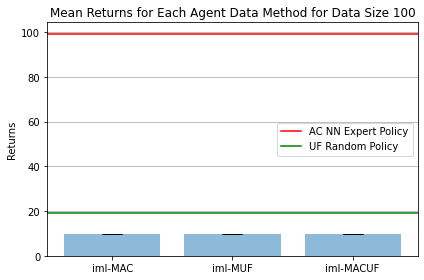

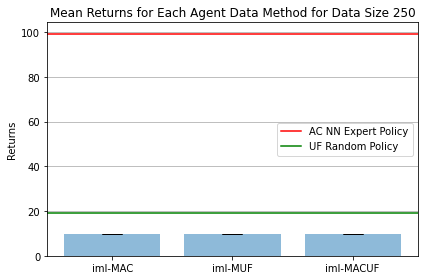

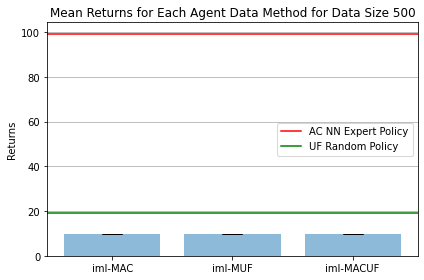

In [186]:
#calculate the average return of the expert ac nn and uf random policy
mean_rewards_ac_nn = np.mean(np.mean(rewards_ac_nn[:,:], axis=0))
mean_rewards_uf = np.mean(np.mean(rewards_uf[:,:], axis=0))

#caluclate the mean and standard deviation of the rewards for each agent data method for each data size
#data size 100
mean_rewards_iml_mac_d1 = np.mean(rewards_iml[0])
std_rewards_iml_mac_d1 = np.std(rewards_iml[0])
mean_rewards_iml_muf_d1 = np.mean(rewards_iml[1])
std_rewards_iml_muf_d1 = np.std(rewards_iml[1])
mean_rewards_iml_macuf_d1 = np.mean(rewards_iml[2])
std_rewards_iml_macuf_d1 = np.std(rewards_iml[2])
#data size 250
mean_rewards_iml_mac_d2 = np.mean(rewards_iml[3])
std_rewards_iml_mac_d2 = np.std(rewards_iml[3])
mean_rewards_iml_muf_d2 = np.mean(rewards_iml[4])
std_rewards_iml_muf_d2 = np.std(rewards_iml[4])
mean_rewards_iml_macuf_d2 = np.mean(rewards_iml[5])
std_rewards_iml_macuf_d2 = np.std(rewards_iml[5])
#data size 500
mean_rewards_iml_mac_d3 = np.mean(rewards_iml[6])
std_rewards_iml_mac_d3 = np.std(rewards_iml[6])
mean_rewards_iml_muf_d3 = np.mean(rewards_iml[7])
std_rewards_iml_muf_d3 = np.std(rewards_iml[7])
mean_rewards_iml_macuf_d3 = np.mean(rewards_iml[8])
std_rewards_iml_macuf_d3 = np.std(rewards_iml[8])


# for data size 100 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['iml-MAC', 'iml-MUF', 'iml-MACUF']
means = [mean_rewards_iml_mac_d1, mean_rewards_iml_muf_d1, mean_rewards_iml_macuf_d1]
stds = [std_rewards_iml_mac_d1, std_rewards_iml_muf_d1, std_rewards_iml_macuf_d1]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 100')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['iml-MAC', 'iml-MUF', 'iml-MACUF']
means = [mean_rewards_iml_mac_d2, mean_rewards_iml_muf_d2, mean_rewards_iml_macuf_d2]
stds = [std_rewards_iml_mac_d2, std_rewards_iml_muf_d2, std_rewards_iml_macuf_d2]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 250')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['iml-MAC', 'iml-MUF', 'iml-MACUF']
means = [mean_rewards_iml_mac_d3, mean_rewards_iml_muf_d3, mean_rewards_iml_macuf_d3]
stds = [std_rewards_iml_mac_d3, std_rewards_iml_muf_d3, std_rewards_iml_macuf_d3]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 500')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


learning rate c = 0.1

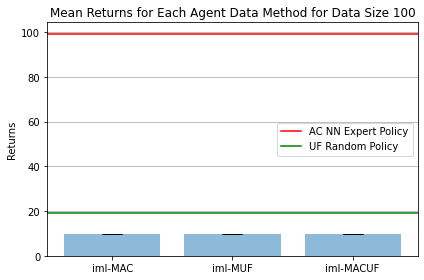

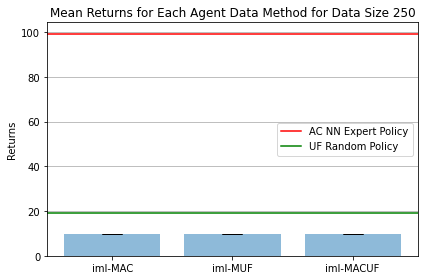

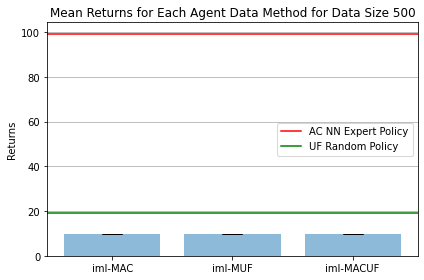

In [190]:
#calculate the average return of the expert ac nn and uf random policy
mean_rewards_ac_nn = np.mean(np.mean(rewards_ac_nn[:,:], axis=0))
mean_rewards_uf = np.mean(np.mean(rewards_uf[:,:], axis=0))

#caluclate the mean and standard deviation of the rewards for each agent data method for each data size
#data size 100
mean_rewards_iml_mac_d1 = np.mean(rewards_iml[0])
std_rewards_iml_mac_d1 = np.std(rewards_iml[0])
mean_rewards_iml_muf_d1 = np.mean(rewards_iml[1])
std_rewards_iml_muf_d1 = np.std(rewards_iml[1])
mean_rewards_iml_macuf_d1 = np.mean(rewards_iml[2])
std_rewards_iml_macuf_d1 = np.std(rewards_iml[2])
#data size 250
mean_rewards_iml_mac_d2 = np.mean(rewards_iml[3])
std_rewards_iml_mac_d2 = np.std(rewards_iml[3])
mean_rewards_iml_muf_d2 = np.mean(rewards_iml[4])
std_rewards_iml_muf_d2 = np.std(rewards_iml[4])
mean_rewards_iml_macuf_d2 = np.mean(rewards_iml[5])
std_rewards_iml_macuf_d2 = np.std(rewards_iml[5])
#data size 500
mean_rewards_iml_mac_d3 = np.mean(rewards_iml[6])
std_rewards_iml_mac_d3 = np.std(rewards_iml[6])
mean_rewards_iml_muf_d3 = np.mean(rewards_iml[7])
std_rewards_iml_muf_d3 = np.std(rewards_iml[7])
mean_rewards_iml_macuf_d3 = np.mean(rewards_iml[8])
std_rewards_iml_macuf_d3 = np.std(rewards_iml[8])


# for data size 100 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['iml-MAC', 'iml-MUF', 'iml-MACUF']
means = [mean_rewards_iml_mac_d1, mean_rewards_iml_muf_d1, mean_rewards_iml_macuf_d1]
stds = [std_rewards_iml_mac_d1, std_rewards_iml_muf_d1, std_rewards_iml_macuf_d1]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 100')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['iml-MAC', 'iml-MUF', 'iml-MACUF']
means = [mean_rewards_iml_mac_d2, mean_rewards_iml_muf_d2, mean_rewards_iml_macuf_d2]
stds = [std_rewards_iml_mac_d2, std_rewards_iml_muf_d2, std_rewards_iml_macuf_d2]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 250')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['iml-MAC', 'iml-MUF', 'iml-MACUF']
means = [mean_rewards_iml_mac_d3, mean_rewards_iml_muf_d3, mean_rewards_iml_macuf_d3]
stds = [std_rewards_iml_mac_d3, std_rewards_iml_muf_d3, std_rewards_iml_macuf_d3]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 500')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


learning rate c = 1

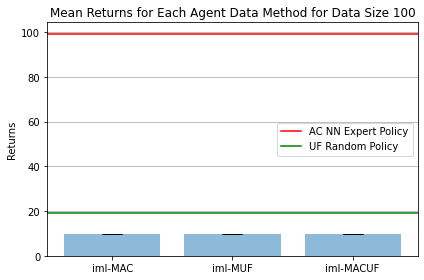

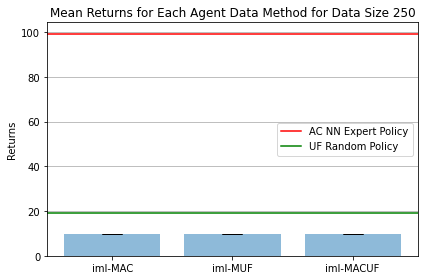

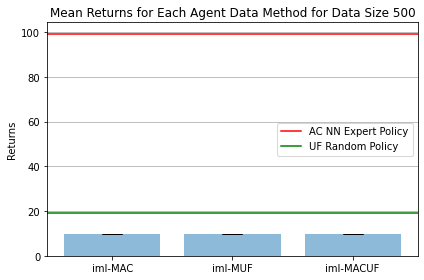

In [193]:
#calculate the average return of the expert ac nn and uf random policy
mean_rewards_ac_nn = np.mean(np.mean(rewards_ac_nn[:,:], axis=0))
mean_rewards_uf = np.mean(np.mean(rewards_uf[:,:], axis=0))

#caluclate the mean and standard deviation of the rewards for each agent data method for each data size
#data size 100
mean_rewards_iml_mac_d1 = np.mean(rewards_iml[0])
std_rewards_iml_mac_d1 = np.std(rewards_iml[0])
mean_rewards_iml_muf_d1 = np.mean(rewards_iml[1])
std_rewards_iml_muf_d1 = np.std(rewards_iml[1])
mean_rewards_iml_macuf_d1 = np.mean(rewards_iml[2])
std_rewards_iml_macuf_d1 = np.std(rewards_iml[2])
#data size 250
mean_rewards_iml_mac_d2 = np.mean(rewards_iml[3])
std_rewards_iml_mac_d2 = np.std(rewards_iml[3])
mean_rewards_iml_muf_d2 = np.mean(rewards_iml[4])
std_rewards_iml_muf_d2 = np.std(rewards_iml[4])
mean_rewards_iml_macuf_d2 = np.mean(rewards_iml[5])
std_rewards_iml_macuf_d2 = np.std(rewards_iml[5])
#data size 500
mean_rewards_iml_mac_d3 = np.mean(rewards_iml[6])
std_rewards_iml_mac_d3 = np.std(rewards_iml[6])
mean_rewards_iml_muf_d3 = np.mean(rewards_iml[7])
std_rewards_iml_muf_d3 = np.std(rewards_iml[7])
mean_rewards_iml_macuf_d3 = np.mean(rewards_iml[8])
std_rewards_iml_macuf_d3 = np.std(rewards_iml[8])


# for data size 100 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['iml-MAC', 'iml-MUF', 'iml-MACUF']
means = [mean_rewards_iml_mac_d1, mean_rewards_iml_muf_d1, mean_rewards_iml_macuf_d1]
stds = [std_rewards_iml_mac_d1, std_rewards_iml_muf_d1, std_rewards_iml_macuf_d1]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 100')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['iml-MAC', 'iml-MUF', 'iml-MACUF']
means = [mean_rewards_iml_mac_d2, mean_rewards_iml_muf_d2, mean_rewards_iml_macuf_d2]
stds = [std_rewards_iml_mac_d2, std_rewards_iml_muf_d2, std_rewards_iml_macuf_d2]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 250')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['iml-MAC', 'iml-MUF', 'iml-MACUF']
means = [mean_rewards_iml_mac_d3, mean_rewards_iml_muf_d3, mean_rewards_iml_macuf_d3]
stds = [std_rewards_iml_mac_d3, std_rewards_iml_muf_d3, std_rewards_iml_macuf_d3]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 500')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


### Fitted Q-learning with linear FA Discrete Binned States (PyTorch) (runs through all 9 data sets)

In [ ]:
#batch training for all agent in fitted Q-learning

#initialize an array to store all 9 experiment agents
fq_sdnets = np.zeros(9, dtype=object)
agent_index = 0

#loop through the selected data lengths
for selected_data in range(len(episode_cs)):
    #loop through the selected methods
    for selected_method in tqdm(range(len(expert_data_all_discrete))):

        fq_sdnet = SD_Net(num_features, num_actions)
        #criterion = nn.MSELoss() #use for linear output
        criterion = nn.BCELoss() #use for sigmoid output

        # optimizer = optim.Adam(fq_sdnet.parameters(), lr=learning_rate)
        optimizer = optim.SGD(fq_sdnet.parameters(), lr=learning_rate)
        # optimizer = optim.RAdam(fq_sdnet.parameters(), lr=learning_rate)

        
        batch_size = int(episode_cs[selected_data] / s)
        K_iterations = int(episode_cs[selected_data]/batch_size) * k
        #print("Max iterations: ", K_iterations)

        # Loop over K_iterations
        c_episode = 0

        #array to store loss values
        loss_values = np.zeros(K_iterations)

        for t in range(K_iterations):
            #check if c_episode is greater than cs_episode, reset c_episode to 0
            if c_episode >= episode_cs[selected_data]:
                #print(f'c_episode: {c_episode} is greater than cs_episode: {episode_cs[selected_data]}')
                c_episode = 0

            # Loop over all episodes in batch and store their ouputs
            batch_indices = np.arange(c_episode, min(c_episode+batch_size, expert_data_ac_uf.shape[0]))
            #print(batch_indices)

            #run until convergence
            prev_loss = 0

            # Loop over episodes in selected batch indices
            expert_batch = expert_data_all_discrete[selected_method][batch_indices]
            
            # Loop over time steps within the episode (load the batches of data)
            for expert_data in expert_batch:
                
                states = torch.stack([torch.from_numpy(a) for a in expert_data[:, 0]]).float()
                actions = torch.stack([torch.from_numpy(a) for a in expert_data[:, 1]]).long()
                next_inputs = torch.stack([torch.from_numpy(a) for a in expert_data[:, 2]]).float()
                rewards = torch.stack([torch.from_numpy(a) for a in expert_data[:, 3]]).float()
                step_size = expert_data.shape[0]


                # store the target Q-value for the current batch
                with torch.no_grad():
                    target_qsa = rewards + gamma * torch.max(fq_sdnet(next_inputs), dim=1)[0]

                # Compute the predicted Q-values for the current state-action pairs
                predicted_qs = fq_sdnet(states)
                #extract the predicted Q-value for the action taken
                predicted_qsa = predicted_qs[range(step_size), actions]

                #clamp predicted probabilities between 1e-7 and 1-1e-7
                #predicted_qsa = torch.clamp(predicted_qsa, 1e-7, 1-1e-7)

                # Compute the loss and update the neural network
                optimizer.zero_grad()
                loss = criterion(predicted_qsa, target_qsa)
                loss.backward()
                optimizer.step()

                # Check for convergence
                if abs(loss - prev_loss) < tolerance:
                    print('Convergence reached after {} episode'.format(c_episode))
                    print('Loss difference: ', abs(loss.item() - prev_loss.item()))
                    break
                
                prev_loss = loss

            # #exit if loss is negative
            # if loss.item() < 0:
            #     print('Loss is negative')
            #     break

            c_episode += batch_size

            #store the loss values
            loss_values[t] = loss.item()
            print(f'Loss - K iteration {t}, {method_dict[selected_method]} data length {episode_cs[selected_data]}: {loss.item()}')

        #save the trained agent
        fq_sdnets[agent_index] = fq_sdnet
        agent_index += 1

In [194]:
#save the trained agents
#np.save('fq_sdnets_adamlr_0001', fq_sdnets)
#np.save('fq_sdnets_adamlr_00001', fq_sdnets)
#np.save('fq_sdnets_adamlr_000001', fq_sdnets)
#np.save('fq_sdnets_sgdlr_01', fq_sdnets)
#np.save('fq_sdnets_sgdlr_001', fq_sdnets)
#np.save('fq_sdnets_sgdlr_0001', fq_sdnets)

#load the trained agents
#fq_sdnets = np.load('fq_sdnets_adamlr_0001.npy', allow_pickle=True)
#fq_sdnets = np.load('fq_sdnets_adamlr_00001.npy', allow_pickle=True)
#fq_sdnets = np.load('fq_sdnets_adamlr_000001.npy', allow_pickle=True)
#fq_sdnets = np.load('fq_sdnets_sgdlr_01.npy', allow_pickle=True)
#fq_sdnets = np.load('fq_sdnets_sgdlr_001.npy', allow_pickle=True)
fq_sdnets = np.load('fq_sdnets_sgdlr_0001.npy', allow_pickle=True)

#### Greedy test run function

In [195]:
#online greedy testing parameters
episode_count = 100

#initialize an array to store the rewards for each episode for each agent
rewards_fq = np.zeros((9, episode_count))

#loop through each agent
for i, q_agent in enumerate(fq_sdnets):

    #Offline training using expert data on a policy network model (supervised)
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    #use encoder to for Fitted Q-learning and discretize the state space
    oh = OneHotFA(env, bins)

    # Initialize a table to count the rewards for each episode
    rewards = np.zeros(episode_count)
    # Initialize a table to count the number of steps for each episode
    steps = np.zeros(episode_count)

    # Loop over episodes
    for ep in range(episode_count):
        # initialize state and action for current episode
        state, info = env.reset(seed=seed) 
        state_discrete, state_index = oh.discretize_state(state)
        truncated = False
        terminated = False

        # Loop over time steps within the episode
        while not (terminated or truncated):

            # Choose the next action using greedy policy
            action = epsilon_greedy(q_agent.to(device), state_discrete, num_actions=num_actions, epsilon=0.0)
            # Take the chosen action and observe the next state and reward
            next_state, reward, terminated, truncated, info = env.step(action)
            # Discretize the next state
            next_state_discrete, next_state_index = oh.discretize_state(next_state)

            # Update the state
            state_discrete = next_state_discrete

            # store the total reward for each episode
            rewards[ep] += reward * (gamma ** steps[ep])

            # store the number of steps for each episode
            steps[ep] += 1

            env.render()


    #save the rewards for each episode for each agent
    rewards_fq[i] = rewards

#close the environment
env.close()

#### results from agents plotted in bar chart

results shown below, lr 0.001: for SGD optimizer

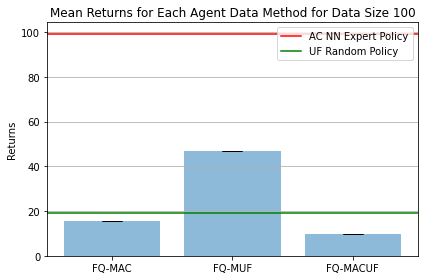

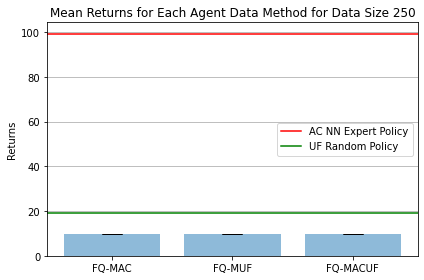

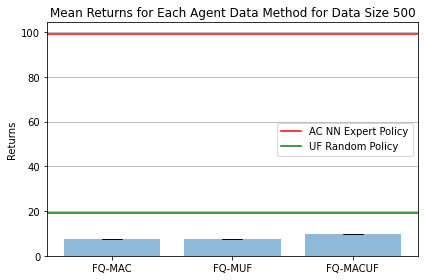

In [196]:
#calculate the average return of the expert ac nn and uf random policy
mean_rewards_ac_nn = np.mean(np.mean(rewards_ac_nn[:,:], axis=0))
mean_rewards_uf = np.mean(np.mean(rewards_uf[:,:], axis=0))

#caluclate the mean and standard deviation of the rewards for each agent data method for each data size
#data size 100
mean_rewards_fq_mac_d1 = np.mean(rewards_fq[0])
std_rewards_fq_mac_d1 = np.std(rewards_fq[0])
mean_rewards_fq_muf_d1 = np.mean(rewards_fq[1])
std_rewards_fq_muf_d1 = np.std(rewards_fq[1])
mean_rewards_fq_macuf_d1 = np.mean(rewards_fq[2])
std_rewards_fq_macuf_d1 = np.std(rewards_fq[2])
#data size 250
mean_rewards_fq_mac_d2 = np.mean(rewards_fq[3])
std_rewards_fq_mac_d2 = np.std(rewards_fq[3])
mean_rewards_fq_muf_d2 = np.mean(rewards_fq[4])
std_rewards_fq_muf_d2 = np.std(rewards_fq[4])
mean_rewards_fq_macuf_d2 = np.mean(rewards_fq[5])
std_rewards_fq_macuf_d2 = np.std(rewards_fq[5])
#data size 500
mean_rewards_fq_mac_d3 = np.mean(rewards_fq[6])
std_rewards_fq_mac_d3 = np.std(rewards_fq[6])
mean_rewards_fq_muf_d3 = np.mean(rewards_fq[7])
std_rewards_fq_muf_d3 = np.std(rewards_fq[7])
mean_rewards_fq_macuf_d3 = np.mean(rewards_fq[8])
std_rewards_fq_macuf_d3 = np.std(rewards_fq[8])


# for data size 100 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['FQ-MAC', 'FQ-MUF', 'FQ-MACUF']
means = [mean_rewards_fq_mac_d1, mean_rewards_fq_muf_d1, mean_rewards_fq_macuf_d1]
stds = [std_rewards_fq_mac_d1, std_rewards_fq_muf_d1, std_rewards_fq_macuf_d1]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 100')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['FQ-MAC', 'FQ-MUF', 'FQ-MACUF']
means = [mean_rewards_fq_mac_d2, mean_rewards_fq_muf_d2, mean_rewards_fq_macuf_d2]
stds = [std_rewards_fq_mac_d2, std_rewards_fq_muf_d2, std_rewards_fq_macuf_d2]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 250')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['FQ-MAC', 'FQ-MUF', 'FQ-MACUF']
means = [mean_rewards_fq_mac_d3, mean_rewards_fq_muf_d3, mean_rewards_fq_macuf_d3]
stds = [std_rewards_fq_mac_d3, std_rewards_fq_muf_d3, std_rewards_fq_macuf_d3]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 500')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


results shown below, lr 0.1: for SGD optimizer

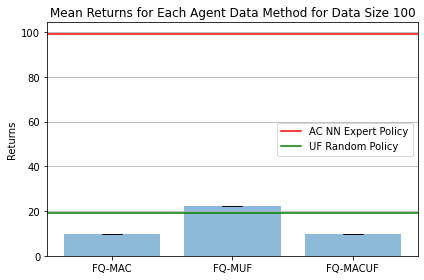

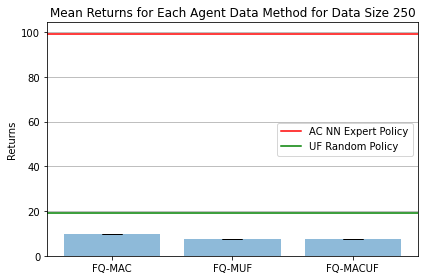

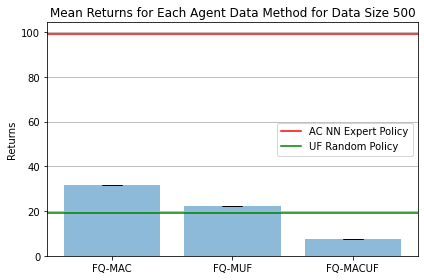

In [178]:
#calculate the average return of the expert ac nn and uf random policy
mean_rewards_ac_nn = np.mean(np.mean(rewards_ac_nn[:,:], axis=0))
mean_rewards_uf = np.mean(np.mean(rewards_uf[:,:], axis=0))

#caluclate the mean and standard deviation of the rewards for each agent data method for each data size
#data size 100
mean_rewards_fq_mac_d1 = np.mean(rewards_fq[0])
std_rewards_fq_mac_d1 = np.std(rewards_fq[0])
mean_rewards_fq_muf_d1 = np.mean(rewards_fq[1])
std_rewards_fq_muf_d1 = np.std(rewards_fq[1])
mean_rewards_fq_macuf_d1 = np.mean(rewards_fq[2])
std_rewards_fq_macuf_d1 = np.std(rewards_fq[2])
#data size 250
mean_rewards_fq_mac_d2 = np.mean(rewards_fq[3])
std_rewards_fq_mac_d2 = np.std(rewards_fq[3])
mean_rewards_fq_muf_d2 = np.mean(rewards_fq[4])
std_rewards_fq_muf_d2 = np.std(rewards_fq[4])
mean_rewards_fq_macuf_d2 = np.mean(rewards_fq[5])
std_rewards_fq_macuf_d2 = np.std(rewards_fq[5])
#data size 500
mean_rewards_fq_mac_d3 = np.mean(rewards_fq[6])
std_rewards_fq_mac_d3 = np.std(rewards_fq[6])
mean_rewards_fq_muf_d3 = np.mean(rewards_fq[7])
std_rewards_fq_muf_d3 = np.std(rewards_fq[7])
mean_rewards_fq_macuf_d3 = np.mean(rewards_fq[8])
std_rewards_fq_macuf_d3 = np.std(rewards_fq[8])


# for data size 100 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['FQ-MAC', 'FQ-MUF', 'FQ-MACUF']
means = [mean_rewards_fq_mac_d1, mean_rewards_fq_muf_d1, mean_rewards_fq_macuf_d1]
stds = [std_rewards_fq_mac_d1, std_rewards_fq_muf_d1, std_rewards_fq_macuf_d1]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 100')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['FQ-MAC', 'FQ-MUF', 'FQ-MACUF']
means = [mean_rewards_fq_mac_d2, mean_rewards_fq_muf_d2, mean_rewards_fq_macuf_d2]
stds = [std_rewards_fq_mac_d2, std_rewards_fq_muf_d2, std_rewards_fq_macuf_d2]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 250')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['FQ-MAC', 'FQ-MUF', 'FQ-MACUF']
means = [mean_rewards_fq_mac_d3, mean_rewards_fq_muf_d3, mean_rewards_fq_macuf_d3]
stds = [std_rewards_fq_mac_d3, std_rewards_fq_muf_d3, std_rewards_fq_macuf_d3]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 500')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


results shown below, best lr: 0.0001 for Adam optimizer

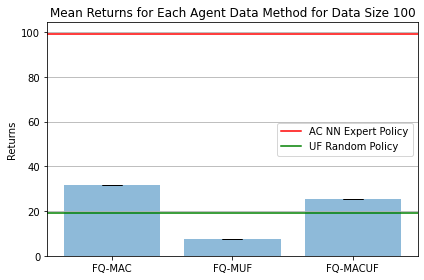

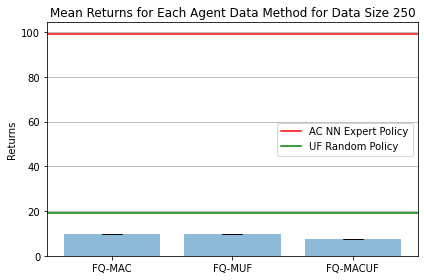

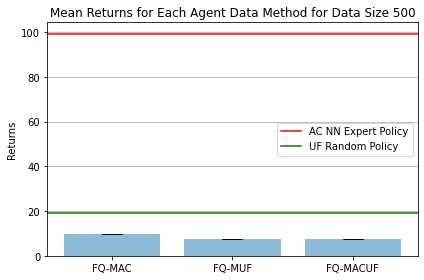

In [183]:
#calculate the average return of the expert ac nn and uf random policy
mean_rewards_ac_nn = np.mean(np.mean(rewards_ac_nn[:,:], axis=0))
mean_rewards_uf = np.mean(np.mean(rewards_uf[:,:], axis=0))

#caluclate the mean and standard deviation of the rewards for each agent data method for each data size
#data size 100
mean_rewards_fq_mac_d1 = np.mean(rewards_fq[0])
std_rewards_fq_mac_d1 = np.std(rewards_fq[0])
mean_rewards_fq_muf_d1 = np.mean(rewards_fq[1])
std_rewards_fq_muf_d1 = np.std(rewards_fq[1])
mean_rewards_fq_macuf_d1 = np.mean(rewards_fq[2])
std_rewards_fq_macuf_d1 = np.std(rewards_fq[2])
#data size 250
mean_rewards_fq_mac_d2 = np.mean(rewards_fq[3])
std_rewards_fq_mac_d2 = np.std(rewards_fq[3])
mean_rewards_fq_muf_d2 = np.mean(rewards_fq[4])
std_rewards_fq_muf_d2 = np.std(rewards_fq[4])
mean_rewards_fq_macuf_d2 = np.mean(rewards_fq[5])
std_rewards_fq_macuf_d2 = np.std(rewards_fq[5])
#data size 500
mean_rewards_fq_mac_d3 = np.mean(rewards_fq[6])
std_rewards_fq_mac_d3 = np.std(rewards_fq[6])
mean_rewards_fq_muf_d3 = np.mean(rewards_fq[7])
std_rewards_fq_muf_d3 = np.std(rewards_fq[7])
mean_rewards_fq_macuf_d3 = np.mean(rewards_fq[8])
std_rewards_fq_macuf_d3 = np.std(rewards_fq[8])


# for data size 100 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['FQ-MAC', 'FQ-MUF', 'FQ-MACUF']
means = [mean_rewards_fq_mac_d1, mean_rewards_fq_muf_d1, mean_rewards_fq_macuf_d1]
stds = [std_rewards_fq_mac_d1, std_rewards_fq_muf_d1, std_rewards_fq_macuf_d1]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 100')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['FQ-MAC', 'FQ-MUF', 'FQ-MACUF']
means = [mean_rewards_fq_mac_d2, mean_rewards_fq_muf_d2, mean_rewards_fq_macuf_d2]
stds = [std_rewards_fq_mac_d2, std_rewards_fq_muf_d2, std_rewards_fq_macuf_d2]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 250')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['FQ-MAC', 'FQ-MUF', 'FQ-MACUF']
means = [mean_rewards_fq_mac_d3, mean_rewards_fq_muf_d3, mean_rewards_fq_macuf_d3]
stds = [std_rewards_fq_mac_d3, std_rewards_fq_muf_d3, std_rewards_fq_macuf_d3]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 500')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


## Offline RL on CartPole v1 (with multi-layer perceptron) Offline Training

In [197]:
# set hyperparameters for training
episode_cs = [100, 250, 500] # number of episode sizes to select from in each experiment
gamma = 0.99 # discount factor

learning_rate = 0.001 #test different learning rates for different optimizers (Adam, SGD)
tolerance = 1e-6 #tolerance for convergence
s = 1 #batch split factor
k = 3 #number of iterations for each full batch episodes

#define a dictionary to map the method names to the corresponding data
method_dict = {0 : 'AC', 1 : 'UF', 2 : 'AC_UF'}

# Neural net that is meant to predict Q values, in two possible ways. 

# Use-case 1: input size 4, output size 2: takes a state and outputs the Q value of this state when taking both actions
#             Input of forward pass should be of the form 
#             [state_var_1, state_var_2, state_var_3, state_var_4]
#             Where the state variables are the variables as provided by gym, as floats, non-binned.

# Use-case 2: input size 5, output size 1: takes a state and action, and outputs the Q value of this state when taking this action
#             Input of forward pas should be of the form 
#             [state_var_1, state_var_2, state_var_3, state_var_4, action]
#             Where the state variables are the variables as provided by gym, as floats, non-binned.
#             Action is 0 for left and 1 for right.


# Small net
class Neural_FA_Q_value_small(nn.Module):
  def __init__(self, n_inputs, n_outputs):
    super(Neural_FA_Q_value_small, self).__init__()
    #Fully connected layers
    self.fc1 = nn.Linear(n_inputs, 6)
    self.fc2 = nn.Linear(6, 4)
    self.fc4 = nn.Linear(4, n_outputs)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc4(x)
    return x


# Large net
class Neural_FA_Q_value_large(nn.Module):

  def __init__(self, n_inputs, n_outputs):
    super(Neural_FA_Q_value_large, self).__init__()

    #Fully connected layers
    self.fc1 = nn.Linear(n_inputs, 16)
    self.fc2 = nn.Linear(16, 16)
    self.fc4 = nn.Linear(16, n_outputs)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc4(x)
    return x


### Fitted Q-learning with Small Net (runs through all 9 data sets)

In [ ]:
#batch training for all agent in fitted Q-learning

#initialize an array to store all 9 experiment agents
fq_mdnets = np.zeros(9, dtype=object)
agent_index = 0

#loop through the selected data lengths
for selected_data in range(len(episode_cs)):
    #loop through the selected methods
    for selected_method in tqdm(range(len(expert_data_all_discrete))):

        fq_mdnet = Neural_FA_Q_value_small(num_states, num_actions)
        criterion = nn.MSELoss() #use for linear output
        #criterion = nn.BCELoss() #use for sigmoid output

        optimizer = optim.Adam(fq_mdnet.parameters(), lr=learning_rate)
        # optimizer = optim.SGD(fq_mdnet.parameters(), lr=learning_rate)
        # optimizer = optim.RAdam(fq_mdnet.parameters(), lr=learning_rate)

        
        batch_size = int(episode_cs[selected_data] / s)
        K_iterations = int(episode_cs[selected_data]/batch_size) * k
        #print("Max iterations: ", K_iterations)

        # Loop over K_iterations
        c_episode = 0

        #array to store loss values
        loss_values = np.zeros(K_iterations)

        for t in range(K_iterations):
            #check if c_episode is greater than cs_episode, reset c_episode to 0
            if c_episode >= episode_cs[selected_data]:
                #print(f'c_episode: {c_episode} is greater than cs_episode: {episode_cs[selected_data]}')
                c_episode = 0

            # Loop over all episodes in batch and store their ouputs
            batch_indices = np.arange(c_episode, min(c_episode+batch_size, expert_data_ac_uf.shape[0]))
            #print(batch_indices)

            #run until convergence
            prev_loss = 0

            # Loop over episodes in selected batch indices
            expert_batch = expert_data_all[selected_method][batch_indices]
            
            # Loop over time steps within the episode (load the batches of data)
            for expert_data in expert_batch:
                
                states = torch.stack([torch.from_numpy(a) for a in expert_data[:, 0]]).float()
                actions = torch.stack([torch.from_numpy(a) for a in expert_data[:, 1]]).long()
                next_inputs = torch.stack([torch.from_numpy(a) for a in expert_data[:, 2]]).float()
                rewards = torch.stack([torch.from_numpy(a) for a in expert_data[:, 3]]).float()
                step_size = expert_data.shape[0]


                # store the target Q-value for the current batch
                with torch.no_grad():
                    target_qsa = rewards + gamma * torch.max(fq_mdnet(next_inputs), dim=1)[0]

                # Compute the predicted Q-values for the current state-action pairs
                predicted_qs = fq_mdnet(states)
                #extract the predicted Q-value for the action taken
                predicted_qsa = predicted_qs[range(step_size), actions]

                #clamp predicted probabilities between 1e-7 and 1-1e-7
                #predicted_qsa = torch.clamp(predicted_qsa, 1e-7, 1-1e-7)

                # Compute the loss and update the neural network
                optimizer.zero_grad()
                loss = criterion(predicted_qsa, target_qsa)
                loss.backward()
                optimizer.step()

                # Check for convergence
                if abs(loss - prev_loss) < tolerance:
                    print('Convergence reached after {} episode'.format(c_episode))
                    print('Loss difference: ', abs(loss.item() - prev_loss.item()))
                    break
                
                prev_loss = loss

            # #exit if loss is negative
            # if loss.item() < 0:
            #     print('Loss is negative')
            #     break

            c_episode += batch_size

            #store the loss values
            loss_values[t] = loss.item()
            print(f'Loss - K iteration {t}, {method_dict[selected_method]} data length {episode_cs[selected_data]}: {loss.item()}')

        #save the trained agent
        fq_mdnets[agent_index] = fq_mdnet
        agent_index += 1

In [216]:
#save the trained agents
#np.save('fq_mdnets_adamlr_0001', fq_mdnets)
#np.save('fq_mdnets_adamlr_00001', fq_mdnets)
#np.save('fq_mdnets_adamlr_000001', fq_mdnets)

#np.save('fq_mdnets_sgdlr_01', fq_mdnets)
#np.save('fq_mdnets_sgdlr_001', fq_mdnets)
#np.save('fq_mdnets_sgdlr_0001', fq_mdnets)

#load the trained agents
#fq_mdnets = np.load('fq_mdnets_adamlr_0001.npy', allow_pickle=True)
fq_mdnets = np.load('fq_mdnets_adamlr_00001.npy', allow_pickle=True)
#fq_mdnets = np.load('fq_mdnets_adamlr_000001.npy', allow_pickle=True)

#fq_mdnets = np.load('fq_mdnets_sgdlr_01.npy', allow_pickle=True)
#fq_mdnets = np.load('fq_mdnets_sgdlr_001.npy', allow_pickle=True)
#fq_mdnets = np.load('fq_mdnets_sgdlr_0001.npy', allow_pickle=True)

#### Greedy test run function

In [217]:
#online greedy testing parameters
episode_count = 100

#initialize an array to store the rewards for each episode for each agent
rewards_mfq = np.zeros((9, episode_count))

#loop through each agent
for i, q_agent in enumerate(fq_mdnets):

    #Offline training using expert data on a policy network model (supervised)
    env = gym.make('CartPole-v1', render_mode='rgb_array')

    # Initialize a table to count the rewards for each episode
    rewards = np.zeros(episode_count)
    # Initialize a table to count the number of steps for each episode
    steps = np.zeros(episode_count)

    # Loop over episodes
    for ep in range(episode_count):
        # initialize state and action for current episode
        state, info = env.reset(seed=seed) 
        truncated = False
        terminated = False

        # Loop over time steps within the episode
        while not (terminated or truncated):

            # Choose the next action using greedy policy
            action = epsilon_greedy(q_agent.to(device), state, num_actions=num_actions, epsilon=0.0)
            # Take the chosen action and observe the next state and reward
            next_state, reward, terminated, truncated, info = env.step(action)

            # Update the state
            state = next_state

            # store the total reward for each episode
            rewards[ep] += reward * (gamma ** steps[ep])

            # store the number of steps for each episode
            steps[ep] += 1

            env.render()


    #save the rewards for each episode for each agent
    rewards_mfq[i] = rewards

#close the environment
env.close()

#### results from agents plotted in bar chart

results shown below, lr 0.001: for Adam optimizer

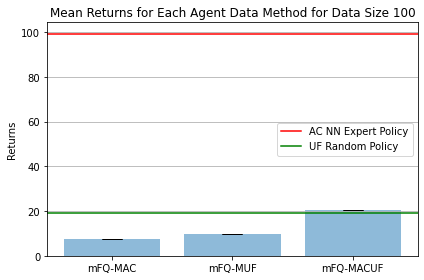

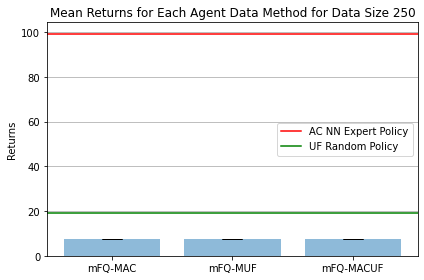

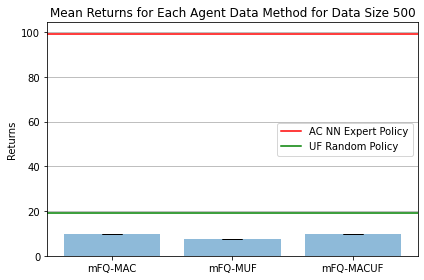

In [215]:
#calculate the average return of the expert ac nn and uf random policy
mean_rewards_ac_nn = np.mean(np.mean(rewards_ac_nn[:,:], axis=0))
mean_rewards_uf = np.mean(np.mean(rewards_uf[:,:], axis=0))

#caluclate the mean and standard deviation of the rewards for each agent data method for each data size
#data size 100
mean_rewards_mfq_mac_d1 = np.mean(rewards_mfq[0])
std_rewards_mfq_mac_d1 = np.std(rewards_mfq[0])
mean_rewards_mfq_muf_d1 = np.mean(rewards_mfq[1])
std_rewards_mfq_muf_d1 = np.std(rewards_mfq[1])
mean_rewards_mfq_macuf_d1 = np.mean(rewards_mfq[2])
std_rewards_mfq_macuf_d1 = np.std(rewards_mfq[2])
#data size 250
mean_rewards_mfq_mac_d2 = np.mean(rewards_mfq[3])
std_rewards_mfq_mac_d2 = np.std(rewards_mfq[3])
mean_rewards_mfq_muf_d2 = np.mean(rewards_mfq[4])
std_rewards_mfq_muf_d2 = np.std(rewards_mfq[4])
mean_rewards_mfq_macuf_d2 = np.mean(rewards_mfq[5])
std_rewards_mfq_macuf_d2 = np.std(rewards_mfq[5])
#data size 500
mean_rewards_mfq_mac_d3 = np.mean(rewards_mfq[6])
std_rewards_mfq_mac_d3 = np.std(rewards_mfq[6])
mean_rewards_mfq_muf_d3 = np.mean(rewards_mfq[7])
std_rewards_mfq_muf_d3 = np.std(rewards_mfq[7])
mean_rewards_mfq_macuf_d3 = np.mean(rewards_mfq[8])
std_rewards_mfq_macuf_d3 = np.std(rewards_mfq[8])


# for data size 100 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d1, mean_rewards_mfq_muf_d1, mean_rewards_mfq_macuf_d1]
stds = [std_rewards_mfq_mac_d1, std_rewards_mfq_muf_d1, std_rewards_mfq_macuf_d1]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 100')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d2, mean_rewards_mfq_muf_d2, mean_rewards_mfq_macuf_d2]
stds = [std_rewards_mfq_mac_d2, std_rewards_mfq_muf_d2, std_rewards_mfq_macuf_d2]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 250')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d3, mean_rewards_mfq_muf_d3, mean_rewards_mfq_macuf_d3]
stds = [std_rewards_mfq_mac_d3, std_rewards_mfq_muf_d3, std_rewards_mfq_macuf_d3]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 500')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


results shown below, lr 0.00001: for Adam optimizer

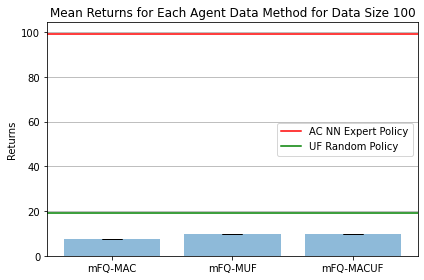

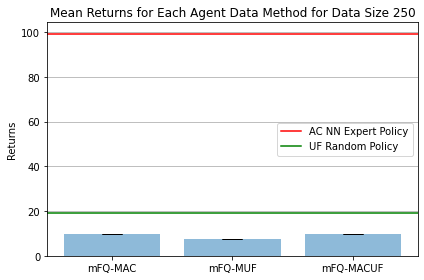

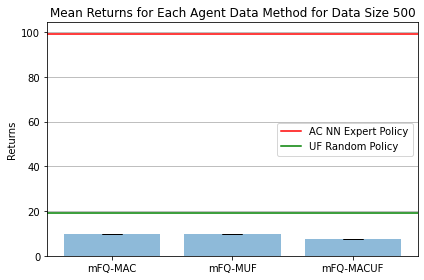

In [211]:
#calculate the average return of the expert ac nn and uf random policy
mean_rewards_ac_nn = np.mean(np.mean(rewards_ac_nn[:,:], axis=0))
mean_rewards_uf = np.mean(np.mean(rewards_uf[:,:], axis=0))

#caluclate the mean and standard deviation of the rewards for each agent data method for each data size
#data size 100
mean_rewards_mfq_mac_d1 = np.mean(rewards_mfq[0])
std_rewards_mfq_mac_d1 = np.std(rewards_mfq[0])
mean_rewards_mfq_muf_d1 = np.mean(rewards_mfq[1])
std_rewards_mfq_muf_d1 = np.std(rewards_mfq[1])
mean_rewards_mfq_macuf_d1 = np.mean(rewards_mfq[2])
std_rewards_mfq_macuf_d1 = np.std(rewards_mfq[2])
#data size 250
mean_rewards_mfq_mac_d2 = np.mean(rewards_mfq[3])
std_rewards_mfq_mac_d2 = np.std(rewards_mfq[3])
mean_rewards_mfq_muf_d2 = np.mean(rewards_mfq[4])
std_rewards_mfq_muf_d2 = np.std(rewards_mfq[4])
mean_rewards_mfq_macuf_d2 = np.mean(rewards_mfq[5])
std_rewards_mfq_macuf_d2 = np.std(rewards_mfq[5])
#data size 500
mean_rewards_mfq_mac_d3 = np.mean(rewards_mfq[6])
std_rewards_mfq_mac_d3 = np.std(rewards_mfq[6])
mean_rewards_mfq_muf_d3 = np.mean(rewards_mfq[7])
std_rewards_mfq_muf_d3 = np.std(rewards_mfq[7])
mean_rewards_mfq_macuf_d3 = np.mean(rewards_mfq[8])
std_rewards_mfq_macuf_d3 = np.std(rewards_mfq[8])


# for data size 100 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d1, mean_rewards_mfq_muf_d1, mean_rewards_mfq_macuf_d1]
stds = [std_rewards_mfq_mac_d1, std_rewards_mfq_muf_d1, std_rewards_mfq_macuf_d1]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 100')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d2, mean_rewards_mfq_muf_d2, mean_rewards_mfq_macuf_d2]
stds = [std_rewards_mfq_mac_d2, std_rewards_mfq_muf_d2, std_rewards_mfq_macuf_d2]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 250')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d3, mean_rewards_mfq_muf_d3, mean_rewards_mfq_macuf_d3]
stds = [std_rewards_mfq_mac_d3, std_rewards_mfq_muf_d3, std_rewards_mfq_macuf_d3]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 500')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


results shown below, lr 0.0001: for Adam optimizer

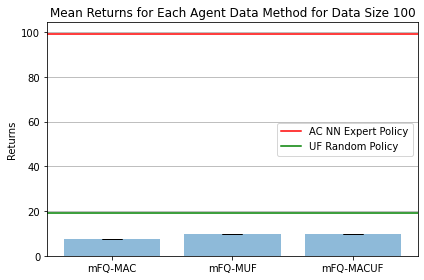

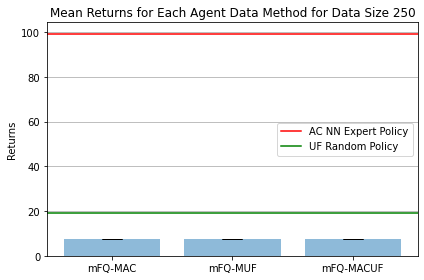

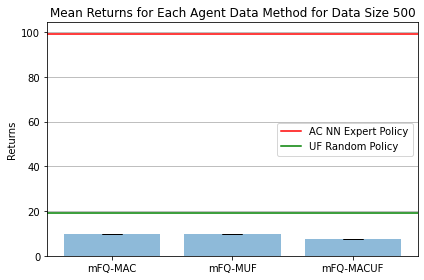

In [218]:
#calculate the average return of the expert ac nn and uf random policy
mean_rewards_ac_nn = np.mean(np.mean(rewards_ac_nn[:,:], axis=0))
mean_rewards_uf = np.mean(np.mean(rewards_uf[:,:], axis=0))

#caluclate the mean and standard deviation of the rewards for each agent data method for each data size
#data size 100
mean_rewards_mfq_mac_d1 = np.mean(rewards_mfq[0])
std_rewards_mfq_mac_d1 = np.std(rewards_mfq[0])
mean_rewards_mfq_muf_d1 = np.mean(rewards_mfq[1])
std_rewards_mfq_muf_d1 = np.std(rewards_mfq[1])
mean_rewards_mfq_macuf_d1 = np.mean(rewards_mfq[2])
std_rewards_mfq_macuf_d1 = np.std(rewards_mfq[2])
#data size 250
mean_rewards_mfq_mac_d2 = np.mean(rewards_mfq[3])
std_rewards_mfq_mac_d2 = np.std(rewards_mfq[3])
mean_rewards_mfq_muf_d2 = np.mean(rewards_mfq[4])
std_rewards_mfq_muf_d2 = np.std(rewards_mfq[4])
mean_rewards_mfq_macuf_d2 = np.mean(rewards_mfq[5])
std_rewards_mfq_macuf_d2 = np.std(rewards_mfq[5])
#data size 500
mean_rewards_mfq_mac_d3 = np.mean(rewards_mfq[6])
std_rewards_mfq_mac_d3 = np.std(rewards_mfq[6])
mean_rewards_mfq_muf_d3 = np.mean(rewards_mfq[7])
std_rewards_mfq_muf_d3 = np.std(rewards_mfq[7])
mean_rewards_mfq_macuf_d3 = np.mean(rewards_mfq[8])
std_rewards_mfq_macuf_d3 = np.std(rewards_mfq[8])


# for data size 100 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d1, mean_rewards_mfq_muf_d1, mean_rewards_mfq_macuf_d1]
stds = [std_rewards_mfq_mac_d1, std_rewards_mfq_muf_d1, std_rewards_mfq_macuf_d1]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 100')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d2, mean_rewards_mfq_muf_d2, mean_rewards_mfq_macuf_d2]
stds = [std_rewards_mfq_mac_d2, std_rewards_mfq_muf_d2, std_rewards_mfq_macuf_d2]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 250')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d3, mean_rewards_mfq_muf_d3, mean_rewards_mfq_macuf_d3]
stds = [std_rewards_mfq_mac_d3, std_rewards_mfq_muf_d3, std_rewards_mfq_macuf_d3]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 500')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


results shown below, lr 0.1: for SGD optimizer

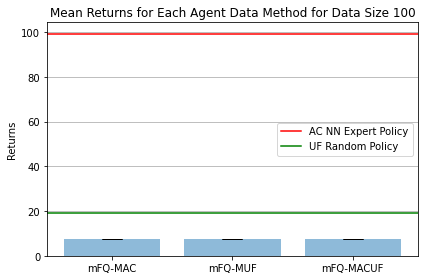

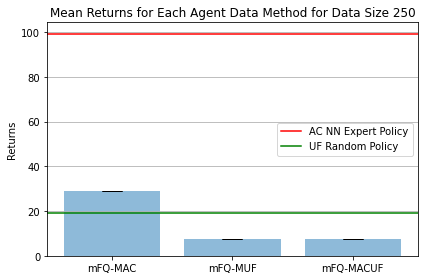

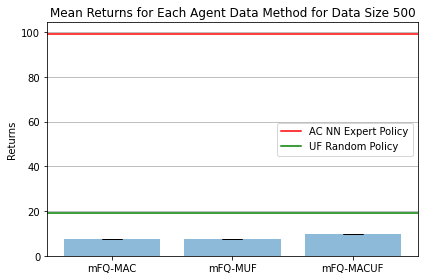

In [208]:
#calculate the average return of the expert ac nn and uf random policy
mean_rewards_ac_nn = np.mean(np.mean(rewards_ac_nn[:,:], axis=0))
mean_rewards_uf = np.mean(np.mean(rewards_uf[:,:], axis=0))

#caluclate the mean and standard deviation of the rewards for each agent data method for each data size
#data size 100
mean_rewards_mfq_mac_d1 = np.mean(rewards_mfq[0])
std_rewards_mfq_mac_d1 = np.std(rewards_mfq[0])
mean_rewards_mfq_muf_d1 = np.mean(rewards_mfq[1])
std_rewards_mfq_muf_d1 = np.std(rewards_mfq[1])
mean_rewards_mfq_macuf_d1 = np.mean(rewards_mfq[2])
std_rewards_mfq_macuf_d1 = np.std(rewards_mfq[2])
#data size 250
mean_rewards_mfq_mac_d2 = np.mean(rewards_mfq[3])
std_rewards_mfq_mac_d2 = np.std(rewards_mfq[3])
mean_rewards_mfq_muf_d2 = np.mean(rewards_mfq[4])
std_rewards_mfq_muf_d2 = np.std(rewards_mfq[4])
mean_rewards_mfq_macuf_d2 = np.mean(rewards_mfq[5])
std_rewards_mfq_macuf_d2 = np.std(rewards_mfq[5])
#data size 500
mean_rewards_mfq_mac_d3 = np.mean(rewards_mfq[6])
std_rewards_mfq_mac_d3 = np.std(rewards_mfq[6])
mean_rewards_mfq_muf_d3 = np.mean(rewards_mfq[7])
std_rewards_mfq_muf_d3 = np.std(rewards_mfq[7])
mean_rewards_mfq_macuf_d3 = np.mean(rewards_mfq[8])
std_rewards_mfq_macuf_d3 = np.std(rewards_mfq[8])


# for data size 100 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d1, mean_rewards_mfq_muf_d1, mean_rewards_mfq_macuf_d1]
stds = [std_rewards_mfq_mac_d1, std_rewards_mfq_muf_d1, std_rewards_mfq_macuf_d1]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 100')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d2, mean_rewards_mfq_muf_d2, mean_rewards_mfq_macuf_d2]
stds = [std_rewards_mfq_mac_d2, std_rewards_mfq_muf_d2, std_rewards_mfq_macuf_d2]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 250')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d3, mean_rewards_mfq_muf_d3, mean_rewards_mfq_macuf_d3]
stds = [std_rewards_mfq_mac_d3, std_rewards_mfq_muf_d3, std_rewards_mfq_macuf_d3]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 500')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


results shown below, lr 0.01: for SGD optimizer

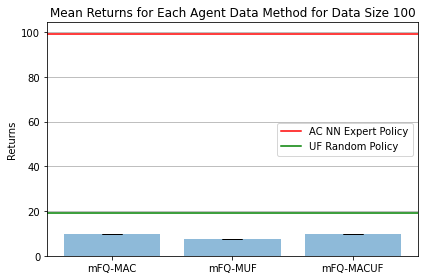

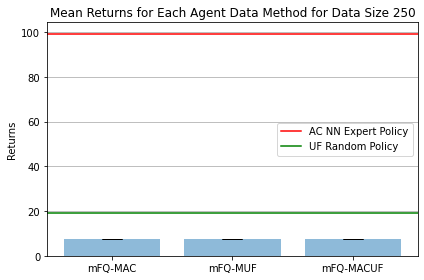

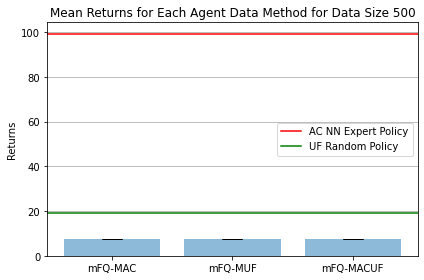

In [205]:
#calculate the average return of the expert ac nn and uf random policy
mean_rewards_ac_nn = np.mean(np.mean(rewards_ac_nn[:,:], axis=0))
mean_rewards_uf = np.mean(np.mean(rewards_uf[:,:], axis=0))

#caluclate the mean and standard deviation of the rewards for each agent data method for each data size
#data size 100
mean_rewards_mfq_mac_d1 = np.mean(rewards_mfq[0])
std_rewards_mfq_mac_d1 = np.std(rewards_mfq[0])
mean_rewards_mfq_muf_d1 = np.mean(rewards_mfq[1])
std_rewards_mfq_muf_d1 = np.std(rewards_mfq[1])
mean_rewards_mfq_macuf_d1 = np.mean(rewards_mfq[2])
std_rewards_mfq_macuf_d1 = np.std(rewards_mfq[2])
#data size 250
mean_rewards_mfq_mac_d2 = np.mean(rewards_mfq[3])
std_rewards_mfq_mac_d2 = np.std(rewards_mfq[3])
mean_rewards_mfq_muf_d2 = np.mean(rewards_mfq[4])
std_rewards_mfq_muf_d2 = np.std(rewards_mfq[4])
mean_rewards_mfq_macuf_d2 = np.mean(rewards_mfq[5])
std_rewards_mfq_macuf_d2 = np.std(rewards_mfq[5])
#data size 500
mean_rewards_mfq_mac_d3 = np.mean(rewards_mfq[6])
std_rewards_mfq_mac_d3 = np.std(rewards_mfq[6])
mean_rewards_mfq_muf_d3 = np.mean(rewards_mfq[7])
std_rewards_mfq_muf_d3 = np.std(rewards_mfq[7])
mean_rewards_mfq_macuf_d3 = np.mean(rewards_mfq[8])
std_rewards_mfq_macuf_d3 = np.std(rewards_mfq[8])


# for data size 100 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d1, mean_rewards_mfq_muf_d1, mean_rewards_mfq_macuf_d1]
stds = [std_rewards_mfq_mac_d1, std_rewards_mfq_muf_d1, std_rewards_mfq_macuf_d1]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 100')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d2, mean_rewards_mfq_muf_d2, mean_rewards_mfq_macuf_d2]
stds = [std_rewards_mfq_mac_d2, std_rewards_mfq_muf_d2, std_rewards_mfq_macuf_d2]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 250')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d3, mean_rewards_mfq_muf_d3, mean_rewards_mfq_macuf_d3]
stds = [std_rewards_mfq_mac_d3, std_rewards_mfq_muf_d3, std_rewards_mfq_macuf_d3]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 500')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


results shown below, lr 0.001: for SGD optimizer

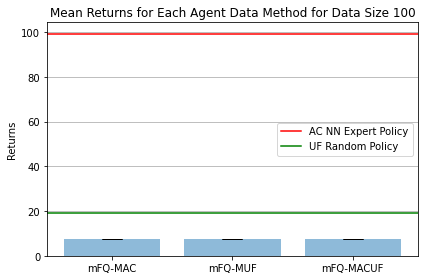

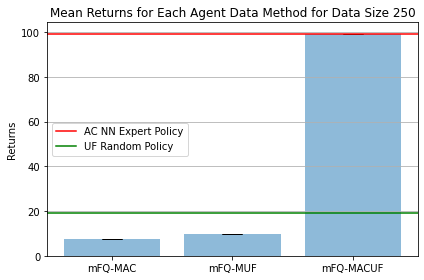

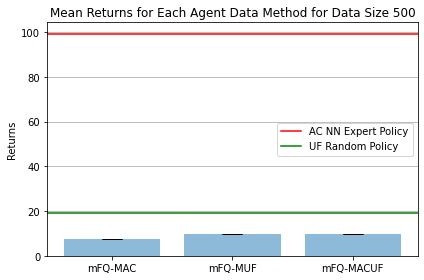

In [200]:
#calculate the average return of the expert ac nn and uf random policy
mean_rewards_ac_nn = np.mean(np.mean(rewards_ac_nn[:,:], axis=0))
mean_rewards_uf = np.mean(np.mean(rewards_uf[:,:], axis=0))

#caluclate the mean and standard deviation of the rewards for each agent data method for each data size
#data size 100
mean_rewards_mfq_mac_d1 = np.mean(rewards_mfq[0])
std_rewards_mfq_mac_d1 = np.std(rewards_mfq[0])
mean_rewards_mfq_muf_d1 = np.mean(rewards_mfq[1])
std_rewards_mfq_muf_d1 = np.std(rewards_mfq[1])
mean_rewards_mfq_macuf_d1 = np.mean(rewards_mfq[2])
std_rewards_mfq_macuf_d1 = np.std(rewards_mfq[2])
#data size 250
mean_rewards_mfq_mac_d2 = np.mean(rewards_mfq[3])
std_rewards_mfq_mac_d2 = np.std(rewards_mfq[3])
mean_rewards_mfq_muf_d2 = np.mean(rewards_mfq[4])
std_rewards_mfq_muf_d2 = np.std(rewards_mfq[4])
mean_rewards_mfq_macuf_d2 = np.mean(rewards_mfq[5])
std_rewards_mfq_macuf_d2 = np.std(rewards_mfq[5])
#data size 500
mean_rewards_mfq_mac_d3 = np.mean(rewards_mfq[6])
std_rewards_mfq_mac_d3 = np.std(rewards_mfq[6])
mean_rewards_mfq_muf_d3 = np.mean(rewards_mfq[7])
std_rewards_mfq_muf_d3 = np.std(rewards_mfq[7])
mean_rewards_mfq_macuf_d3 = np.mean(rewards_mfq[8])
std_rewards_mfq_macuf_d3 = np.std(rewards_mfq[8])


# for data size 100 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d1, mean_rewards_mfq_muf_d1, mean_rewards_mfq_macuf_d1]
stds = [std_rewards_mfq_mac_d1, std_rewards_mfq_muf_d1, std_rewards_mfq_macuf_d1]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 100')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d2, mean_rewards_mfq_muf_d2, mean_rewards_mfq_macuf_d2]
stds = [std_rewards_mfq_mac_d2, std_rewards_mfq_muf_d2, std_rewards_mfq_macuf_d2]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 250')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['mFQ-MAC', 'mFQ-MUF', 'mFQ-MACUF']
means = [mean_rewards_mfq_mac_d3, mean_rewards_mfq_muf_d3, mean_rewards_mfq_macuf_d3]
stds = [std_rewards_mfq_mac_d3, std_rewards_mfq_muf_d3, std_rewards_mfq_macuf_d3]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 500')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


## Results of all best agents comparisons plotted in bar chart

Best agent for imitation learning
Logistic regression, C=1

Best agent for Fitted Q-learning with linear FA Discrete Binned States
SGD optimizer, lr=0.001
(Adam optimizer, lr=0.0001, interesting results)
different optimizer seem to give different results*

Best agent for Fitted Q-learning with Small Net MLP
SGD optimizer, lr=0.001

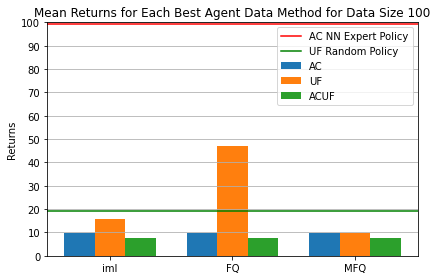

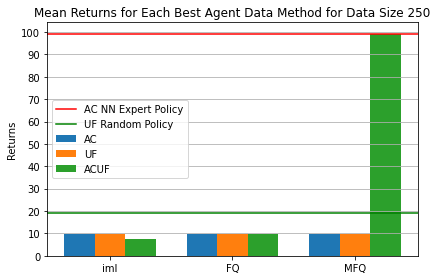

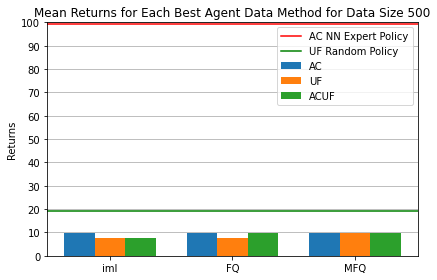

In [201]:
#calculate the average return of the expert ac nn and uf random policy
mean_rewards_ac_nn = np.mean(np.mean(rewards_ac_nn[:,:], axis=0))
mean_rewards_uf = np.mean(np.mean(rewards_uf[:,:], axis=0))

#caluclate the mean and standard deviation of the rewards for each agent data method for each data size
#data size 100
mean_rewards_iml_mac_d1 = np.mean(rewards_iml[0])
std_rewards_iml_mac_d1 = np.std(rewards_iml[0])
mean_rewards_iml_muf_d1 = np.mean(rewards_iml[1])
std_rewards_iml_muf_d1 = np.std(rewards_iml[1])
mean_rewards_iml_macuf_d1 = np.mean(rewards_iml[2])
std_rewards_iml_macuf_d1 = np.std(rewards_iml[2])
#data size 250
mean_rewards_iml_mac_d2 = np.mean(rewards_iml[3])
std_rewards_iml_mac_d2 = np.std(rewards_iml[3])
mean_rewards_iml_muf_d2 = np.mean(rewards_iml[4])
std_rewards_iml_muf_d2 = np.std(rewards_iml[4])
mean_rewards_iml_macuf_d2 = np.mean(rewards_iml[5])
std_rewards_iml_macuf_d2 = np.std(rewards_iml[5])
#data size 500
mean_rewards_iml_mac_d3 = np.mean(rewards_iml[6])
std_rewards_iml_mac_d3 = np.std(rewards_iml[6])
mean_rewards_iml_muf_d3 = np.mean(rewards_iml[7])
std_rewards_iml_muf_d3 = np.std(rewards_iml[7])
mean_rewards_iml_macuf_d3 = np.mean(rewards_iml[8])
std_rewards_iml_macuf_d3 = np.std(rewards_iml[8])

#caluclate the mean and standard deviation of the rewards for each agent data method for each data size
#data size 100
mean_rewards_mfq_mac_d1 = np.mean(rewards_mfq[0])
std_rewards_mfq_mac_d1 = np.std(rewards_mfq[0])
mean_rewards_mfq_muf_d1 = np.mean(rewards_mfq[1])
std_rewards_mfq_muf_d1 = np.std(rewards_mfq[1])
mean_rewards_mfq_macuf_d1 = np.mean(rewards_mfq[2])
std_rewards_mfq_macuf_d1 = np.std(rewards_mfq[2])
#data size 250
mean_rewards_mfq_mac_d2 = np.mean(rewards_mfq[3])
std_rewards_mfq_mac_d2 = np.std(rewards_mfq[3])
mean_rewards_mfq_muf_d2 = np.mean(rewards_mfq[4])
std_rewards_mfq_muf_d2 = np.std(rewards_mfq[4])
mean_rewards_mfq_macuf_d2 = np.mean(rewards_mfq[5])
std_rewards_mfq_macuf_d2 = np.std(rewards_mfq[5])
#data size 500
mean_rewards_mfq_mac_d3 = np.mean(rewards_mfq[6])
std_rewards_mfq_mac_d3 = np.std(rewards_mfq[6])
mean_rewards_mfq_muf_d3 = np.mean(rewards_mfq[7])
std_rewards_mfq_muf_d3 = np.std(rewards_mfq[7])
mean_rewards_mfq_macuf_d3 = np.mean(rewards_mfq[8])
std_rewards_mfq_macuf_d3 = np.std(rewards_mfq[8])


#caluclate the mean and standard deviation of the rewards for each agent data method for each data size
#data size 100
mean_rewards_fq_mac_d1 = np.mean(rewards_fq[0])
std_rewards_fq_mac_d1 = np.std(rewards_fq[0])
mean_rewards_fq_muf_d1 = np.mean(rewards_fq[1])
std_rewards_fq_muf_d1 = np.std(rewards_fq[1])
mean_rewards_fq_macuf_d1 = np.mean(rewards_fq[2])
std_rewards_fq_macuf_d1 = np.std(rewards_fq[2])
#data size 250
mean_rewards_fq_mac_d2 = np.mean(rewards_fq[3])
std_rewards_fq_mac_d2 = np.std(rewards_fq[3])
mean_rewards_fq_muf_d2 = np.mean(rewards_fq[4])
std_rewards_fq_muf_d2 = np.std(rewards_fq[4])
mean_rewards_fq_macuf_d2 = np.mean(rewards_fq[5])
std_rewards_fq_macuf_d2 = np.std(rewards_fq[5])
#data size 500
mean_rewards_fq_mac_d3 = np.mean(rewards_fq[6])
std_rewards_fq_mac_d3 = np.std(rewards_fq[6])
mean_rewards_fq_muf_d3 = np.mean(rewards_fq[7])
std_rewards_fq_muf_d3 = np.std(rewards_fq[7])
mean_rewards_fq_macuf_d3 = np.mean(rewards_fq[8])
std_rewards_fq_macuf_d3 = np.std(rewards_fq[8])


# for data size 100 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['iml','FQ','MFQ']
means = [mean_rewards_iml_mac_d1, mean_rewards_iml_muf_d1, mean_rewards_iml_macuf_d1, mean_rewards_fq_mac_d1, mean_rewards_fq_muf_d1, mean_rewards_fq_macuf_d1, mean_rewards_mfq_mac_d1, mean_rewards_mfq_muf_d1, mean_rewards_mfq_macuf_d1]
stds = [std_rewards_iml_mac_d1, std_rewards_iml_muf_d1, std_rewards_iml_macuf_d1, std_rewards_fq_mac_d1, std_rewards_fq_muf_d1, std_rewards_fq_macuf_d1, std_rewards_mfq_mac_d1, std_rewards_mfq_muf_d1, std_rewards_mfq_macuf_d1]   
fig, ax = plt.subplots()
# group every 3 bars together with different colors
means_1 = means[0:3]
means_2 = means[3:6]
means_3 = means[6:9]
stds_1 = stds[0:3]
stds_2 = stds[3:6]
stds_3 = stds[6:9]
x = np.arange(len(x_labels))  # the label locations
width = 0.25  # the width of the bars
color_1 = 'tab:blue'
color_2 = 'tab:orange'
color_3 = 'tab:green'
rects1 = ax.bar(x - width, means_1, width, yerr=stds_1, label='AC', color=color_1)
rects2 = ax.bar(x, means_2, width, yerr=stds_2, label='UF', color=color_2)
rects3 = ax.bar(x + width, means_3, width, yerr=stds_3, label='ACUF', color=color_3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Best Agent Data Method for Data Size 100')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()
ax.yaxis.grid(True)
#y axis show tick every 10 units
ax.set_yticks(np.arange(0, 110, 10)) 


# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['iml','FQ','MFQ']
means = [mean_rewards_iml_mac_d2, mean_rewards_iml_muf_d2, mean_rewards_iml_macuf_d2, mean_rewards_fq_mac_d2, mean_rewards_fq_muf_d2, mean_rewards_fq_macuf_d2, mean_rewards_mfq_mac_d2, mean_rewards_mfq_muf_d2, mean_rewards_mfq_macuf_d2]
stds = [std_rewards_iml_mac_d2, std_rewards_iml_muf_d2, std_rewards_iml_macuf_d2, std_rewards_fq_mac_d2, std_rewards_fq_muf_d2, std_rewards_fq_macuf_d2, std_rewards_mfq_mac_d2, std_rewards_mfq_muf_d2, std_rewards_mfq_macuf_d2]
fig, ax = plt.subplots()
# group every 3 bars together with different colors
means_1 = means[0:3]
means_2 = means[3:6]
means_3 = means[6:9]
stds_1 = stds[0:3]
stds_2 = stds[3:6]
stds_3 = stds[6:9]
x = np.arange(len(x_labels))  # the label locations
width = 0.25  # the width of the bars
color_1 = 'tab:blue'
color_2 = 'tab:orange'
color_3 = 'tab:green'
rects1 = ax.bar(x - width, means_1, width, yerr=stds_1, label='AC', color=color_1)
rects2 = ax.bar(x, means_2, width, yerr=stds_2, label='UF', color=color_2)
rects3 = ax.bar(x + width, means_3, width, yerr=stds_3, label='ACUF', color=color_3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Best Agent Data Method for Data Size 250')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()
ax.yaxis.grid(True)
#y axis show tick every 10 units
ax.set_yticks(np.arange(0, 110, 10)) 

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 500 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['iml','FQ','MFQ']
means = [mean_rewards_iml_mac_d3, mean_rewards_iml_muf_d3, mean_rewards_iml_macuf_d3, mean_rewards_fq_mac_d3, mean_rewards_fq_muf_d3, mean_rewards_fq_macuf_d3, mean_rewards_mfq_mac_d3, mean_rewards_mfq_muf_d3, mean_rewards_mfq_macuf_d3]
stds = [std_rewards_iml_mac_d3, std_rewards_iml_muf_d3, std_rewards_iml_macuf_d3, std_rewards_fq_mac_d3, std_rewards_fq_muf_d3, std_rewards_fq_macuf_d3, std_rewards_mfq_mac_d3, std_rewards_mfq_muf_d3, std_rewards_mfq_macuf_d3]
fig, ax = plt.subplots()
# group every 3 bars together with different colors
means_1 = means[0:3]
means_2 = means[3:6]
means_3 = means[6:9]
stds_1 = stds[0:3]
stds_2 = stds[3:6]
stds_3 = stds[6:9]
x = np.arange(len(x_labels))  # the label locations
width = 0.25  # the width of the bars
color_1 = 'tab:blue'
color_2 = 'tab:orange'
color_3 = 'tab:green'
rects1 = ax.bar(x - width, means_1, width, yerr=stds_1, label='AC', color=color_1)
rects2 = ax.bar(x, means_2, width, yerr=stds_2, label='UF', color=color_2)
rects3 = ax.bar(x + width, means_3, width, yerr=stds_3, label='ACUF', color=color_3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Best Agent Data Method for Data Size 500')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()
ax.yaxis.grid(True)
#y axis show tick every 10 units
ax.set_yticks(np.arange(0, 110, 10)) 

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



## (CartPole State Discretization Method) Sample CartPole environment velocities to calculate the bins discretization

In [ ]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

num_episodes = 100
num_runs = 10
seeds = [0, 137, 2, 3, 4, 42, 6, 7, 8, 9]

cart_velocities = []
pole_velocities = []
for run in range(num_runs):
    print("Run {}".format(run))
    cart_evm = []
    pole_evm = []
    for episode in range(num_episodes):
        obs, info = env.reset(seed=seeds[run])
        truncated = False
        terminated = False
        cart_ev = []
        pole_ev = []
        while not (truncated or terminated):
            action = env.action_space.sample()
            obs, reward, terminated, truncated, info = env.step(action)
            cart_ev.append(obs[1])
            pole_ev.append(obs[3])
            env.render()

        cart_evm.append(np.mean(cart_ev))
        pole_evm.append(np.mean(pole_ev))

    cart_velocities.append(cart_evm)
    pole_velocities.append(pole_evm)

cart_velocities = np.array(cart_velocities)
pole_velocities = np.array(pole_velocities)

print("Mean velocity: {:.2f}".format(np.mean(cart_velocities)))
print("Variance of velocity: {:.2f}".format(np.var(cart_velocities)))
print("Minimum velocity: {:.2f}".format(np.min(cart_velocities)))
print("Maximum velocity: {:.2f}".format(np.max(cart_velocities)))


In [ ]:
# plot the histogram of the cart velocities 
c_mean_velocity = np.mean(cart_velocities)
c_std_velocity = np.std(cart_velocities)

# plot the histogram of the pole velocities
p_mean_velocity = np.mean(pole_velocities)
p_std_velocity = np.std(pole_velocities)

# Define bins based on normal distribution of velocities for cart
bins_c = [-np.inf]
for i in range(1, 10):
    bin_start = (i - 5) * c_std_velocity/2
    bins_c.append(bin_start)
bins_c.append(np.inf)
# Create histogram of velocities
hist, bin_edges = np.histogram(cart_velocities, bins=bins_c)
print("Histogram of velocities:")
for i in range(len(hist)):
    print("[{:.2f}, {:.2f}): {}".format(bin_edges[i], bin_edges[i+1], hist[i]))

# Define bins based on normal distribution of velocities for pole
bins = [-np.inf]
for i in range(1, 10):
    bin_start = (i - 5) * p_std_velocity/2
    bins.append(bin_start)
bins.append(np.inf)
# Create histogram of velocities
hist, bin_edges = np.histogram(pole_velocities, bins=bins)
print("Histogram of velocities:")
for i in range(len(hist)):
    print("[{:.2f}, {:.2f}): {}".format(bin_edges[i], bin_edges[i+1], hist[i]))

print(bins_c)
print(bins)